# GNN Experiment Pipeline: IMBD-MULTI Dataset
Αυτό το notebook εκτελεί πείραμα για το μοντέλο GIN (GRAPH ISOMORPHISM NETWORK) χρησιμοποιώντας το dataset IMBD-MULTI.

**Διαδικασία:**
1. Φόρτωση & Ανάλυση Δεδομένων.
2. Εκπαίδευση με 10-Fold Cross-Validation.
3. Αξιολόγηση Μοντέλου σε classification, clustering & stability analysis.
4. Hyperparameter Tuning (προαιρετικά).

Απαραίτητη η ενεργοποίηση της GPU.



## Δομή και Επεξήγηση Εξόδου (Pipeline Output)

Κατά την εκτέλεση του `run_pipeline`, η διαδικασία χωρίζεται σε 4 στάδια.

### 1. Ανάλυση Δεδομένων (Dataset Analysis)
Στην αρχή, το script φορτώνει το dataset **ENZYMES** και τυπώνει μια σύνοψη των χαρακτηριστικών του.
* Πίνακα με `Total Graphs`, `Num Classes`, και μέσους όρους κόμβων/ακμών.
* **Παραγόμενο Αρχείο:** `dataset_info.png` (οπτικοποίηση κατανομής κλάσεων).

### 2. Κύριο Πείραμα (Main Experiment - 10-Fold CV)
Το σύστημα εκτελεί Cross-Validation 10 επαναλήψεων (Folds). Για κάθε Fold:
* **Εκπαίδευση (Training):** Εμφανίζεται η πρόοδος ανά 10 εποχές με το Training Loss και το Validation Accuracy, και σε plot.
* **Εξαγωγή Embeddings:** Μόλις ολοκληρωθεί η εκπαίδευση, το μοντέλο παράγει τα embeddings (`Saved: embeddings_fold_X.npz`).
* **Αξιολόγηση (Evaluation):** Τα embeddings τροφοδοτούνται σε ταξινομητές (SVM, Random Forest, MLP), καθώς και εφαρμόζεται αλγόριθμος kmeans και spectral clustering. Τέλος, εμφανίζεται ένας πίνακας με τα αποτελέσματα του συγκεκριμένου Fold.
* **Ανάλυση Σταθερότητας (Stability):** Το μοντέλο δοκιμάζεται σε δεδομένα με θόρυβο για να ελεγχθεί η ανθεκτικότητά του, και παράγονται τα αντίστοιχα αρχεία.
* Αποθηκεύονται τα embeddings και το μοντέλο για περεταίρω ανάλυση.

### 3. Συγκεντρωτικά Αποτελέσματα (Final Aggregated Results)
Στο τέλος της εκτέλεσης (μετά το Fold 10), τυπώνεται η ενότητα `FINAL AGGREGATED RESULTS`.
* **Internal GNN Metrics:** Η μέση επίδοση του GIN μοντέλου (Accuracy, F1, AUC) σε όλο το Cross-Validation (Μορφή: $\text{Mean} \pm \text{Std}$).
* **External Classifier Metrics:** Η μέση επίδοση των SVM, RF, MLP, μαζί με την τιμή του kmean ARI.
* **Stability Metrics:** Πόσο πέφτει η ακρίβεια όταν προσθέτουμε/αφαιρούμε ακμές, μαζί με αντίστοιχα διαγράμματα.

### 4. Παραγόμενα Αρχεία
Στο τέλος, στον φάκελο εργασίας αποθηκεύονται τα εξής αρχεία για περαιτέρω ανάλυση:
* `experiment_results.csv`: Αναλυτικός πίνακας με όλες τις μετρήσεις για κάθε Fold ξεχωριστά.
* `final_stats.json`: Οι μέσοι όροι και οι τυπικές αποκλίσεις σε μορφή JSON.
* `embeddings_fold_1.npz`: 10 τέτοια αρχεία με τα embeddings από κάθε fold.
* `model_fold_1.pth`: 10 τέτοια αρχεία με τα μοντέλα από κάθε fold.
* `robustness_model_acc.png`: Γράφημα που δείχνει την πτώση της ακρίβειας καθώς αυξάνεται ο θόρυβος στον γράφο.
* `resource_usage.png`: Γράφημα χρόνου εκτέλεσης και χρήσης μνήμης RAM.

imports

In [1]:
# @title
!pip install -q torch_geometric
!pip install -q torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html

import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 37.6 MB/s eta 0:00:00
PyTorch Version: 2.9.0+cu126
CUDA Available: True


In [2]:
# @title
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os
import time
import psutil
import json
import tracemalloc
import random

from torch.nn import LazyLinear, BatchNorm1d
from torch_geometric.nn.models import GIN
from torch_geometric.nn import global_add_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import degree
import torch_geometric.transforms as T

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import accuracy_score, adjusted_rand_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.decomposition import PCA

from IPython.display import Image, display

from sklearn.model_selection import GridSearchCV

import pandas as pd

import datetime

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
import copy
import torch.nn.init as init

import itertools
from collections import defaultdict

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so
  import torch_geometric.typing


helpers for loging time and memory usage

In [3]:
# @title
SCRIPT_START_TIME = time.time()

In [4]:
# @title
def log_status(message):
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    current_ram = mem_info.rss / (1024 ** 2)
    elapsed_seconds = time.time() - SCRIPT_START_TIME
    elapsed_str = str(datetime.timedelta(seconds=int(elapsed_seconds)))
    print(f"[Elapsed: {elapsed_str}] [RAM: {current_ram:.1f} MB] {message}")

In [5]:
# @title
class ResourceTracker:
    def __init__(self, tag=""):
        self.tag = tag
        self.start_time = None
        self.end_time = None
        self.peak_mem = 0

    def __enter__(self):
        self.start_time = time.time()
        tracemalloc.start()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end_time = time.time()
        _, peak = tracemalloc.get_traced_memory()
        self.peak_mem = peak / (1024 * 1024)
        tracemalloc.stop()

    @property
    def duration(self):
        return self.end_time - self.start_time

    @property
    def memory_mb(self):
        return self.peak_mem

helpers for visualization

In [6]:
# @title
# ==============================================================================
# HELPER: VISUALIZATION FUNCTIONS
# ==============================================================================

def plot_dataset_info(dataset, save_path="dataset_info.png"):
    """
    Plots Class Distribution & Graph Size Statistics (Nodes/Edges).
    """
    y = [data.y.item() for data in dataset]
    classes, counts = np.unique(y, return_counts=True)

    num_nodes = [data.num_nodes for data in dataset]
    num_edges = [data.num_edges for data in dataset]

    print("\n" + "="*40)
    print("      DATASET SUMMARY")
    print("="*40)
    print(f"Total Graphs:    {len(dataset)}")
    print(f"Num Classes:     {len(classes)}")
    print(f"Avg Nodes/Graph: {np.mean(num_nodes):.2f} (Min: {min(num_nodes)}, Max: {max(num_nodes)})")
    print(f"Avg Edges/Graph: {np.mean(num_edges):.2f} (Min: {min(num_edges)}, Max: {max(num_edges)})")
    print("-" * 40)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    bars = ax1.bar(classes, counts, color='skyblue', edgecolor='black', alpha=0.8)
    ax1.set_xlabel('Class Label', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    ax1.set_xticks(classes)

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}', ha='center', va='bottom')

    ax2.hist(num_nodes, bins=30, color='salmon', edgecolor='black', alpha=0.8)
    ax2.set_xlabel('Number of Nodes per Graph', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Graph Size Distribution (Nodes)', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    avg_nodes = np.mean(num_nodes)
    ax2.axvline(avg_nodes, color='red', linestyle='dashed', linewidth=2, label=f'Avg: {avg_nodes:.1f}')
    ax2.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()
    print(f"[Visuals] Saved extended dataset info to {save_path}")


def plot_final_metrics(all_results, save_path="final_performance_summary.png"):
    """
    Plots Bar Chart of Accuracy vs F1 vs AUC with Error Bars.
    """

    print("\n[Visuals] Generating Final Performance Summary Plot with Error Bars...")

    df = pd.DataFrame(all_results)
    means = df.mean().to_dict()
    stds  = df.std().to_dict()

    models = ["Internal_GIN_Val", "SVM_Lin", "SVM_RBF", "RF", "MLP"]
    labels = ["GIN (Internal)", "SVM (Linear)", "SVM (RBF)", "Random Forest", "MLP (External)"]

    acc_means = [means.get(f"{m}_Acc", 0) for m in models]
    acc_stds  = [stds.get(f"{m}_Acc", 0)  for m in models]
    f1_means  = [means.get(f"{m}_F1", 0)  for m in models]
    f1_stds   = [stds.get(f"{m}_F1", 0)   for m in models]
    auc_means = [means.get(f"{m}_AUC", 0) for m in models]
    auc_stds  = [stds.get(f"{m}_AUC", 0)  for m in models]

    x = np.arange(len(models))
    width = 0.25
    fig, ax = plt.subplots(figsize=(14, 8))

    rects1 = ax.bar(x - width, acc_means, width, yerr=acc_stds, capsize=5,
                    label='Accuracy', color='blue', edgecolor='black', alpha=0.9)

    rects2 = ax.bar(x, f1_means, width, yerr=f1_stds, capsize=5,
                    label='F1 Score', color='red', edgecolor='black', alpha=0.9)

    rects3 = ax.bar(x + width, auc_means, width, yerr=auc_stds, capsize=5,
                    label='AUC', color='green', edgecolor='black', alpha=0.9)

    ax.set_ylabel('Score (0-1)')
    title_suffix = "Results"
    ax.set_title(f'Final Model Performance (Mean ± Std Dev) Internal GIN vs. External Classifiers')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_ylim(0, 1.15)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()
    print(f"[Visuals] Saved final summary to {save_path}")

def plot_fold_performance(final_stats, filename="fold_performance.png"):
    """
    Plots the scores of all classifiers + KMeans across all folds.
    """

    plt.figure(figsize=(14, 7))

    sample_key = next(iter(final_stats))
    num_folds = len(final_stats[sample_key])
    folds = range(1, num_folds + 1)

    styles = {
        "Internal_GIN_Val_Acc": {'marker': '*', 'label': 'GIN Internal (Val)', 'color': 'purple', 'linewidth': 2.5, 'markersize': 10},
        "SVM_Lin_Acc": {'marker': 'o', 'label': 'SVM Linear', 'color': 'tab:blue'},
        "SVM_RBF_Acc": {'marker': 's', 'label': 'SVM RBF',    'color': 'tab:orange'},
        "RF_Acc":      {'marker': '^', 'label': 'Random Forest','color': 'tab:green'},
        "MLP_Acc":     {'marker': 'd', 'label': 'MLP',        'color': 'tab:red'},
        "KMeans_ARI":  {'marker': 'x', 'label': 'KMeans (ARI)', 'color': 'black', 'linestyle': '--', 'linewidth': 2}
    }

    for name, scores in final_stats.items():
        if name in styles:
            style = styles[name]
            plt.plot(folds, scores, **style)

    plt.title(f'Classifier Accuracy & KMeans ARI per Fold ({num_folds} Folds)', fontsize=14)
    plt.xlabel('Fold Number', fontsize=12)
    plt.ylabel('Score (Accuracy / ARI)', fontsize=12)
    plt.xticks(folds)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    plt.close()
    print(f"[Visuals] Saved fold performance plot: {filename}")
    return filename

def plot_fold_training_curves(train_histories, val_histories, filename="fold_training_curves.png"):
    """
    Plots Training and Validation curves side-by-side.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    if isinstance(train_histories, dict):
        iterator = train_histories.items()
    else:
        iterator = enumerate(train_histories)

    for fold_idx, history in iterator:
        epochs = range(1, len(history) + 1)
        ax1.plot(epochs, history, alpha=0.6, linewidth=1.5, label=f'Fold {fold_idx+1}')

    ax1.set_title('Training Accuracy per Fold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # 2. Plot Validation Curves (if provided)
    if val_histories:
        if isinstance(val_histories, dict):
            iterator = val_histories.items()
        else:
            iterator = enumerate(val_histories)

        for fold_idx, history in iterator:
            epochs = range(1, len(history) + 1)
            ax2.plot(epochs, history, alpha=0.6, linewidth=1.5, label=f'Fold {fold_idx+1}')

        ax2.set_title('Validation Accuracy per Fold')
        ax2.set_xlabel('Epochs')
        ax2.grid(True, linestyle='--', alpha=0.5)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    else:
        pass

    plt.suptitle('Learning Curves: Train vs. Validation (All Folds)', fontsize=16)
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.show()
    plt.close()
    print(f"[Visuals] Saved training curves: {filename}")
    return filename

def plot_cluster_comparison(X, y_true, y_kmeans, y_spectral, save_path):
    """
    Plots 2D t-SNE embeddings thrice side-by-side:
    1. Ground Truth
    2. K-Means
    3. Spectral Clustering
    """

    print("Computing t-SNE for cluster comparison...")
    tsne = TSNE(n_components=2, perplexity=50, random_state=42, init='pca', learning_rate='auto')
    z = tsne.fit_transform(X)
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    scatter_kwargs = {'s': 50, 'alpha': 0.8, 'edgecolors': 'w', 'linewidth': 0.2}
    # --- PLOT 1: GROUND TRUTH ---
    scatter1 = axes[0].scatter(z[:, 0], z[:, 1], c=y_true, cmap='tab10', **scatter_kwargs)
    axes[0].set_title("GT (t-SNE)", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    # --- PLOT 2: K-MEANS ---
    scatter2 = axes[1].scatter(z[:, 0], z[:, 1], c=y_kmeans, cmap='tab10', **scatter_kwargs)
    axes[1].set_title("KMeans (t-SNE)", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    # --- PLOT 3: SPECTRAL ---
    scatter3 = axes[2].scatter(z[:, 0], z[:, 1], c=y_spectral, cmap='tab10', **scatter_kwargs)
    axes[2].set_title("Spectral (t-SNE)", fontsize=14, fontweight='bold')
    axes[2].axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"[Visuals] Saved 3-panel cluster comparison to {save_path}")

def plot_stability_comparison(res_clean, res_noisy, stab_score):
    """
    Plots grouped bars for Accuracy/F1/ARI comparing Clean vs Noisy.
    """
    metrics = ['SVM_Lin_Acc', 'SVM_RBF_Acc', 'RF_Acc', 'MLP_Acc', 'KMeans_ARI']
    labels  = ['SVM (Lin)', 'SVM (RBF)', 'Random Forest', 'MLP', 'KMeans ARI']

    clean_vals = [res_clean.get(m, 0) for m in metrics]
    noisy_vals = [res_noisy.get(m, 0) for m in metrics]
    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, clean_vals, width, label='Original', color='#2ca02c', alpha=0.8)
    rects2 = ax.bar(x + width/2, noisy_vals, width, label='Perturbed (+20% Edges)', color='#d62728', alpha=0.8)
    ax.set_ylabel('Score (0-1)')
    ax.set_title(f'Stability Analysis: Performance Drop under Noise\nEmbedding Stability Score: {stab_score:.3f}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylim(0, 1.15)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1)
    autolabel(rects2)
    plt.tight_layout()
    save_path = "stability_comparison_plot.png"
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"[Visuals] Saved stability comparison to {save_path}")

In [7]:
# @title
def plot_training_results(fold, train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Val Accuracy')
    plt.title(f'Fold {fold+1}: Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-', label='Val Loss')
    plt.title(f'Fold {fold+1}: Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"learning_curve_fold_{fold+1}.png")
    plt.show()

resource visualization

In [8]:
# @title
def plot_resource_usage(all_results, save_path="resource_usage.png"):
    """
    Plots Training vs Generation Time with Error Bars and numeric text labels.
    """
    df = pd.DataFrame(all_results)
    means = df.mean(numeric_only=True)
    stds = df.std(numeric_only=True)

    methods = ["GIN", "SVM_Lin", "SVM_RBF", "RF", "MLP"]

    # Extract Data
    train_times = [means.get(f"{m}_Train_Time", 0) for m in methods]
    train_err   = [stds.get(f"{m}_Train_Time", 0) for m in methods]

    gen_times   = [means.get(f"{m}_Gen_Time", 0) for m in methods]
    gen_err     = [stds.get(f"{m}_Gen_Time", 0) for m in methods]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    bars1 = ax1.bar(methods, train_times, yerr=train_err, capsize=5,
                    color='orange', edgecolor='black', alpha=0.7)

    ax1.set_title("Average Training Time (sec)", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Seconds")
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

    max_h1 = 0
    for rect, err in zip(bars1, train_err):
        height = rect.get_height()
        y_pos = height + err
        max_h1 = max(max_h1, y_pos)

        ax1.text(rect.get_x() + rect.get_width()/2., y_pos + (0.02 * max(train_times)),
                 f'{height:.2f}\n±{err:.2f}',
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

    ax1.set_ylim(0, max_h1 * 1.25)


    bars2 = ax2.bar(methods, gen_times, yerr=gen_err, capsize=5,
                    color='teal', edgecolor='black', alpha=0.7)

    ax2.set_title("Average Generation/Inference Time (sec)", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Seconds")
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    max_h2 = 0
    for rect, err in zip(bars2, gen_err):
        height = rect.get_height()
        y_pos = height + err
        max_h2 = max(max_h2, y_pos)

        ax2.text(rect.get_x() + rect.get_width()/2., y_pos + (0.02 * max(gen_times)),
                 f'{height:.3f}\n±{err:.3f}',
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

    ax2.set_ylim(0, max_h2 * 1.25)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"[Visuals] Saved resource usage report to {save_path}")
    print("\n" + "="*70)
    print("      RESOURCE CONSUMPTION REPORT (Mean ± Std)")
    print("="*70)
    print(f"{'Method':<10} | {'Train Time (s)':<20} | {'Gen Time (s)':<20} | {'Peak RAM (MB)':<15}")
    print("-" * 75)

    def fmt(m, s): return f"{m:.2f} ± {s:.2f}"

    # GIN
    t_m = means.get('GIN_Train_Time',0); t_s = stds.get('GIN_Train_Time',0)
    g_m = means.get('GIN_Gen_Time',0);   g_s = stds.get('GIN_Gen_Time',0)
    r_m = means.get('GIN_Peak_RAM_MB',0);r_s = stds.get('GIN_Peak_RAM_MB',0)

    print(f"{'GIN':<10} | {fmt(t_m, t_s):<20} | {fmt(g_m, g_s):<20} | {fmt(r_m, r_s):<15}")

    for m in methods[1:]:
        t_m = means.get(f'{m}_Train_Time',0); t_s = stds.get(f'{m}_Train_Time',0)
        g_m = means.get(f'{m}_Gen_Time',0);   g_s = stds.get(f'{m}_Gen_Time',0)
        print(f"{m:<10} | {fmt(t_m, t_s):<20} | {fmt(g_m, g_s):<20} | {'-'}")

helper for picking fold with the best clustering and visualising

In [9]:
# @title
def best_clustering_fold(row_data, title_prefix):
        """
        Loads a specific fold's embeddings and plots the cluster comparison.
        """
        fold_idx = int(row_data['fold_idx'])
        ari_score = row_data.get(f'{title_prefix}_ARI', 0)
        if title_prefix == "Best_Performance":
             ari_score = row_data.get('MLP_Acc', 0)

        print(f">> Generating plot for {title_prefix} (Fold {fold_idx+1})...")

        try:
            data = np.load(f"embeddings_fold_{fold_idx+1}.npz")
            X_val, y_val = data['X_val'], data['y_val']

            n_classes = 3
            kmeans = KMeans(n_clusters=n_classes, n_init=20, random_state=42)
            k_labels = kmeans.fit_predict(X_val)

            spectral = SpectralClustering(n_clusters=n_classes, affinity='nearest_neighbors', random_state=42)
            s_labels = spectral.fit_predict(X_val)

            plot_cluster_comparison(
                X_val, y_val, k_labels, s_labels,
                save_path=f"best_{title_prefix.lower()}_fold_{fold_idx+1}.png"
            )
        except FileNotFoundError:
            print(f"!! Warning: Could not find embeddings for fold {fold_idx+1}. Skipping plot.")

helpers for stability analysis

In [10]:
# @title
def perturb_dataset(dataset, noise_level, mode='add'):
    """
    Perturbs the dataset by adding or removing edges.
    """
    log_status("Perturb Dataset...")
    perturbed_list = []

    for data in dataset:
        data = data.clone()
        num_edges = data.num_edges
        num_perturb = int(noise_level * num_edges)

        if mode == 'add':
            # --- ADD EDGES ---
            num_nodes = data.num_nodes
            src = torch.randint(0, num_nodes, (num_perturb,))
            dst = torch.randint(0, num_nodes, (num_perturb,))
            new_edges = torch.stack([src, dst], dim=0)
            data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)

        elif mode == 'remove':
            # --- REMOVE EDGES ---
            num_perturb = min(num_perturb, num_edges)
            num_keep = num_edges - num_perturb
            if num_keep > 0:
                perm = torch.randperm(num_edges)
                keep_indices = perm[:num_keep]
                data.edge_index = data.edge_index[:, keep_indices]
            else:
                data.edge_index = torch.empty((2, 0), dtype=torch.long)

        perturbed_list.append(data)

    return perturbed_list

plot stability analysis results

In [11]:
# @title
def plot_stability_summary(df_results, save_path="final_stability_dual_plot.png"):
    """
    Creates a side-by-side bar chart showing:
    1. Model Accuracy vs Noise
    2. Cosine Similarity vs Noise
    *NOW INCLUDES DATA LABELS ON BARS*
    """
    print(f">> Generating Dual Stability Summary Plot to {save_path}...")

    master_csv = "stability_detailed_ALL_FOLDS.csv"
    if not os.path.exists(master_csv):
        print(f"!! WARNING: {master_csv} not found. Cannot plot Cosine Similarity.")
        return

    df_detailed = pd.read_csv(master_csv)

    plot_df = df_detailed[df_detailed['Mode'] != 'Clean'].copy()

    plot_df['Mode'] = plot_df['Mode'].str.lower()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    sns.set_style("whitegrid")

    palette = {"add": "green", "remove": "red"}

    bar1 = sns.barplot(
        data=plot_df,
        x="Noise_Level", y="Model_Accuracy", hue="Mode",
        ax=ax1, palette=palette, capsize=.1, edgecolor='k', errorbar='sd'
    )
    ax1.set_title("Robustness: Model Accuracy (Mean ± Std)", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Accuracy Score")
    ax1.set_xlabel("Noise Level")
    ax1.set_ylim(0, 1.15)

    bar2 = sns.barplot(
        data=plot_df,
        x="Noise_Level", y="Cosine_Similarity", hue="Mode",
        ax=ax2, palette=palette, capsize=.1, edgecolor='k', errorbar='sd'
    )
    ax2.set_title("Stability: Embedding Cosine Similarity (Mean ± Std)", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Similarity (Relative to Clean)")
    ax2.set_xlabel("Noise Level")
    ax2.set_ylim(0.9, 1.02)

    def add_labels(ax, decimals=4):
        for container in ax.containers:

            try:
                ax.bar_label(container, fmt=f'%.{decimals}f', padding=3, fontsize=9, fontweight='bold')
            except AttributeError:
                for rect in container:
                    height = rect.get_height()
                    if height > 0:
                        ax.text(
                            rect.get_x() + rect.get_width() / 2,
                            height,
                            f"{height:.{decimals}f}",
                            ha='center', va='bottom',
                            fontsize=9, fontweight='bold'
                        )

    add_labels(ax1, decimals=2)
    add_labels(ax2, decimals=4)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"[Plots] Saved dual stability plot to {save_path}")

In [12]:
# @title
def plot_robustness_curve(df_detailed, metric="Model_Accuracy", save_path="robustness_curve.png", ylabel="Score"):
    """
    Plots the degradation of a specific metric Model_Accuracy as noise increases.
    """

    print(f">> Generating Robustness Curve for {metric}...")
    if df_detailed.empty:
        print("!! Dataframe is empty. Skipping robustness curve.")
        return

    df_clean = df_detailed[df_detailed['Mode'] == 'Clean'].copy()
    df_add   = df_detailed[df_detailed['Mode'] == 'add'].copy()
    df_rem   = df_detailed[df_detailed['Mode'] == 'remove'].copy()

    clean_add = df_clean.copy()
    clean_add['Mode'] = 'add'

    clean_rem = df_clean.copy()
    clean_rem['Mode'] = 'remove'

    df_plot = pd.concat([clean_add, clean_rem, df_add, df_rem], ignore_index=True)

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    palette = {"add": "green", "remove": "red"}


    sns.lineplot(
        data=df_plot,
        x="Noise_Level",
        y=metric,
        hue="Mode",
        palette=palette,
        style="Mode",
        markers=True,
        dashes=False,
        linewidth=2.5,
        errorbar='sd'
    )

    plt.title(f"Model Robustness: {metric} vs. Structural Noise", fontsize=14, fontweight='bold')
    plt.xlabel("Noise Level (Ratio of Edges)", fontsize=12)
    plt.ylabel(f"{metric} Score", fontsize=12)

    vals = df_plot['Noise_Level'].unique()
    plt.xticks(vals, [f"{int(x*100)}%" for x in sorted(vals)])

    plt.legend(title="Perturbation Type", loc='lower left')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"[Plots] Saved robustness curve to {save_path}")

Plot hyperparameter tradeoff

In [13]:
# @title
def plot_tuning_results(results_dict, save_path="tuning_tradeoff.png"):
    """Plots Accuracy vs Compute Cost (Time) for different dimensions."""
    dims = results_dict["dim"]
    accs = [x * 100 for x in results_dict["accuracy"]]
    times = results_dict["training_time"]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Embedding Dimension', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Validation Accuracy (%)', color=color, fontsize=12, fontweight='bold')
    ax1.plot(dims, accs, color=color, marker='o', linewidth=3, label='Accuracy')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Training Time (s)', color=color, fontsize=12, fontweight='bold')
    ax2.plot(dims, times, color=color, marker='s', linestyle='--', linewidth=2, label='Compute Cost')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Hyperparameter Tuning:\nAccuracy vs. Compute Cost', fontsize=14)
    plt.xticks(dims)
    fig.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"[Plot] Saved tuning tradeoff to {save_path}")

# GIN IMPLEMENTATION

*GIN_CONFIG: Προτείνεται από το paper https://arxiv.org/pdf/1810.00826 για social networks όπως το IMBD.*

In [14]:
# ==============================================================================
# GLOBAL HYPERPARAMETERS
# ==============================================================================
GIN_CONFIG = {
    # Model Architecture
    "hidden_channels": 64,
    "num_layers": 5,
    "dropout": 0.5,
    "train_eps": True,

    # Training
    "lr": 0.01,
    "weight_decay": 1e-4,
    "step_size": 50,
    "gamma": 0.5
}

In [15]:
# ==============================================================================
# 1. GIN MODEL
# ==============================================================================
class GINModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()

        dim        = kwargs.get("hidden_dim", GIN_CONFIG["hidden_channels"])
        num_layers = kwargs.get("num_layers", GIN_CONFIG["num_layers"])
        dropout    = kwargs.get("dropout",    GIN_CONFIG["dropout"])
        train_eps  = kwargs.get("train_eps",  GIN_CONFIG["train_eps"])

        # Paper Specs: Sum Pooling, JK=Cat, train_eps trainable
        self.gin = GIN(
            in_channels=in_channels,
            hidden_channels=dim,
            num_layers=num_layers,
            dropout=dropout,
            norm=BatchNorm1d(dim),
            jk="cat",
            train_eps=train_eps
        )
        # Internal Head for Supervised Training
        #self.internal_head = LazyLinear(out_channels)
        input_dim = dim
        self.internal_head = torch.nn.Sequential(
            torch.nn.Linear(input_dim, dim),
            torch.nn.BatchNorm1d(dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(dim, out_channels)   # Final Prediction
        )

    def get_embedding(self, x, edge_index, batch):

      node_embeddings = self.gin(x, edge_index)
      #all_node_feats = torch.cat([x, node_embeddings], dim=-1)
      graph_emb = global_add_pool(node_embeddings, batch)
      return graph_emb

    def forward(self, x, edge_index, batch):
        """Forward pass for Adam Optimizer"""
        emb = self.get_embedding(x, edge_index, batch)
        #return self.internal_head(emb)
        return emb

Train and save

In [21]:
# @title
# ==============================================================================
# 2. TRAIN LOOP
# ==============================================================================

def train_and_save(fold_idx, train_loader, val_loader, dataset, device, filename, hyperparams=None):
    """
    Trains a gin model with Early Stopping and saves embeddings from the best epoch.
    """

    stats = {}
    log_status(f"--- Fold {fold_idx+1}: Initializing GIN ---")

    if hyperparams is None: hyperparams = {}

    # 1. Initialize Model
    model = GINModel(dataset.num_features, dataset.num_classes, **hyperparams).to(device)

    learning_rate = hyperparams.get("lr", GIN_CONFIG["lr"])
    w_decay = hyperparams.get("weight_decay", GIN_CONFIG["weight_decay"])

    # 2. Optimizer & Scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=w_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=GIN_CONFIG["step_size"], gamma=GIN_CONFIG["gamma"])

    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    #     optimizer,
    #     T_max=350,
    #     eta_min=0.0001
    # )

    log_status("Starting Training Loop...")
    with ResourceTracker("GIN_Train") as rt_train:

      # 3. Training Config
      MAX_EPOCHS = 150
      # TRY NO EARLY STOPPING BUT STILL KEEP BEST MODEL OUT OF EVERY EPOCH
      # patience = 30
      # patience_counter = 0

      # 4. State Tracking for Best Model
      best_val_loss = float('inf')
      best_model_wts = copy.deepcopy(model.state_dict())
      best_epoch = 0

      # List to store training accuracy per epoch
      train_acc_history = []
      val_acc_history = []
      train_loss_history = []
      val_loss_history = []

      # --- MAIN LOOP ---
      for epoch in range(1, MAX_EPOCHS + 1):
          # --- TRAIN STEP ---
          model.train()
          total_loss = 0
          total_correct = 0
          total_examples = 0

          for data in train_loader:
              data = data.to(device)
              optimizer.zero_grad()

              # Forward pass
              out = model(data.x, data.edge_index, data.batch)
              loss = F.cross_entropy(out, data.y)

              # Backward pass
              loss.backward()
              optimizer.step()
              total_loss += loss.item()

              pred = out.argmax(dim=1)
              total_correct += int((pred == data.y).sum())
              total_examples += data.y.size(0)

          scheduler.step()
          avg_train_loss = total_loss / len(train_loader)

          epoch_train_acc = total_correct / total_examples if total_examples > 0 else 0
          train_acc_history.append(epoch_train_acc)
          train_loss_history.append(avg_train_loss)

          # --- VALIDATION STEP (Run EVERY epoch) ---
          model.eval()
          val_loss = 0
          correct = 0
          total = 0

          with torch.no_grad():
              for data in val_loader:
                  data = data.to(device)
                  out = model(data.x, data.edge_index, data.batch)

                  # Track Loss
                  val_loss += F.cross_entropy(out, data.y).item()

                  # Track Accuracy
                  pred = out.argmax(dim=1)
                  correct += (pred == data.y).sum().item()
                  total += data.y.size(0)

          avg_val_loss = val_loss / len(val_loader)
          val_acc = correct / total if total > 0 else 0

          val_acc_history.append(val_acc)
          val_loss_history.append(avg_val_loss)

          if avg_val_loss < best_val_loss:
              best_val_loss = avg_val_loss
              best_model_wts = copy.deepcopy(model.state_dict())
              best_epoch = epoch
              # patience_counter = 0
          # else:
          #     patience_counter += 1

          # --- LOGGING ---
          if epoch % 10 == 0:
              # log_status(f"Epoch {epoch:03d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} (Acc: {val_acc:.4f}) | Patience: {patience_counter}/{patience}")
              log_status(f"Epoch {epoch:03d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} (Acc: {val_acc:.4f})")

          # --- EARLY STOPPING TRIGGER ---
          # if patience_counter >= patience:
          #     log_status(f"Early stopping triggered at Epoch {epoch}. Best model was Epoch {best_epoch}.")
          #     break

    log_status("Training finished.")
    stats["GIN_Train_Time"] = rt_train.duration
    stats["GIN_Peak_RAM_MB"] = rt_train.memory_mb

    # --- RESTORE BEST WEIGHTS ---
    log_status(f"Restoring best model from Epoch {best_epoch} with Val Loss {best_val_loss:.4f}")
    model.load_state_dict(best_model_wts)

    # --- FINAL METRIC CALCULATION (ACC, F1, AUC) ---
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            logits = model(data.x, data.edge_index, data.batch)
            probs = F.softmax(logits, dim=1)  # Probabilities for AUC
            preds = logits.argmax(dim=1)      # Hard labels for Acc/F1

            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(data.y.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_probs = torch.cat(all_probs).numpy()

    final_acc = accuracy_score(y_true, y_pred)
    final_f1 = f1_score(y_true, y_pred, average='weighted') # Handles class imbalance

    try:
        if dataset.num_classes == 2:
            final_auc = roc_auc_score(y_true, y_probs[:, 1])
        else:
            final_auc = roc_auc_score(y_true, y_probs, multi_class='ovr', average='weighted')
    except ValueError:
        final_auc = 0.5
    print(f"\n[Fold {fold_idx+1} FINAL RESULTS]")
    print(f"   > Best Val Acc: {final_acc*100:.2f}%")
    print(f"   > F1-Score:     {final_f1:.4f}")
    print(f"   > AUC:          {final_auc:.4f}")
    print("-" * 40)

    stats["Internal_GIN_Val_Acc"] = final_acc
    stats["Internal_GIN_Val_F1"] = final_f1
    stats["Internal_GIN_Val_AUC"] = final_auc

    # --- SAVE MODEL ---
    weight_path = f"model_fold_{fold_idx+1}.pth"
    torch.save(model.state_dict(), weight_path)

    # --- EXTRACT EMBEDDINGS ---
    def extract(loader):
        vecs, labels = [], []
        model.eval()
        with torch.no_grad():
            for data in loader:
                data = data.to(device)
                emb = model.get_embedding(data.x, data.edge_index, data.batch)
                vecs.append(emb.detach().cpu().numpy())
                labels.append(data.y.cpu().numpy())
        return np.concatenate(vecs), np.concatenate(labels)

    log_status("Extracting embeddings...")

    with ResourceTracker("GIN_Gen") as rt_gen:
      X_train, y_train = extract(train_loader)
      X_val, y_val = extract(val_loader)

    stats["GIN_Gen_Time"] = rt_gen.duration
    print(f"   > Generated Embedding Dimensions: {X_train.shape}")

    # --- SAVE EMBEDDINGS ---
    np.savez(filename, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
    log_status(f"Saved: {filename}")

    plot_training_results(fold_idx, train_acc_history, val_acc_history, train_loss_history, val_loss_history)

    return filename, train_acc_history, val_acc_history, model, stats

Evaluate classifiers

In [17]:
# @title
# ==============================================================================
# 3. EVALUATION
# ==============================================================================
def evaluate_classifiers(filename, fold_idx, n_classes=3):
    log_status(f"Loading '{filename}' for Evaluation...")
    data = np.load(filename)
    X_train, y_train = data['X_train'], data['y_train']
    X_val, y_val     = data['X_val'], data['y_val']

    results = {}

    # ==========================================================================
    # SUPERVISED CLASSIFIERS
    # ==========================================================================

    classifiers = {
        "SVM_Lin": make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, max_iter=10000)),
        "SVM_RBF": make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, max_iter=10000)),
        "RF":      RandomForestClassifier(n_estimators=50, n_jobs=1, random_state=42),
        "MLP":     make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42))
    }

    print(f"\n   [Fold {fold_idx+1} Evaluation]")
    print(f"   {'Model':<10} | {'Acc':<8} | {'F1':<8} | {'AUC':<8} | {'Time(s)':<8}")
    print("   " + "-"*60)

    for name, model in classifiers.items():

        clean_name = name.strip()

        with ResourceTracker() as rt_train:
            try:
              model.fit(X_train, y_train)
            except Exception as e:
              print(f"   !! Error training {name}: {e}")
              continue
        results[f"{clean_name}_Train_Time"] = rt_train.duration

        with ResourceTracker() as rt_gen:
            pred = model.predict(X_val)
            # PROBABILITIES REQUIRED FOR AUC
            prob = model.predict_proba(X_val)
        results[f"{clean_name}_Gen_Time"] = rt_gen.duration

        # Acc and F1
        acc = accuracy_score(y_val, pred)
        f1  = f1_score(y_val, pred, average='weighted')

        # AUC
        try:
            auc = roc_auc_score(y_val, prob, multi_class='ovr', average='weighted')
        except ValueError:
            auc = 0.5

        results[f"{clean_name}_Acc"] = acc
        results[f"{clean_name}_F1"]  = f1
        results[f"{clean_name}_AUC"] = auc
        print(f"   {clean_name:<10} | {acc*100:.1f}%   | {f1*100:.1f}%   | {auc:.3f}    | {rt_train.duration:.2f}s")

    # ==========================================================================
    # UNSUPERVISED: K-Means
    # ==========================================================================
    kmeans = KMeans(n_clusters=n_classes, n_init=20, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_val)

    kmeans_ari = adjusted_rand_score(y_val, kmeans_labels)
    results["KMeans_ARI"] = kmeans_ari
    print(f"   >> KMeans ARI: {kmeans_ari:.4f}")

    # ==========================================================================
    # UNSUPERVISED: Spectral Clustering
    # ==========================================================================
    spectral = SpectralClustering(n_clusters=n_classes,
                                  affinity='nearest_neighbors',
                                  random_state=42,
                                  n_neighbors=10)
    spectral_labels = spectral.fit_predict(X_val)
    spectral_ari = adjusted_rand_score(y_val, spectral_labels)
    results["Spectral_ARI"] = spectral_ari
    print(f"   >> Spectral ARI: {spectral_ari:.4f}")
    print("   " + "="*60 + "\n")

    # ==========================================================================
    # VISUALIZATION ONLY FOR FOLD 0
    # ==========================================================================
    if fold_idx == 0:
        plot_cluster_comparison(
            X_val,
            y_val,
            kmeans_labels,
            spectral_labels,
            save_path="pca_cluster_comparison_fold_1.png"
        )

    return results

Stability analysis

In [18]:
# @title
def run_stability_analysis(dataset, device, fold_idx, model=None, model_path=None):
    """
    Comprehensive Stability Analysis:
    - Calculates Cosine Similarity between Clean and Noisy validation sets.
    - Evaluates downstream performance on noisy data.
    - Saves a detailed CSV for this fold.
    - Returns summary_stats for main pipeline aggregation.
    """

    print(f"\n>> ] Running Analysis for Fold {fold_idx+1}...")

    # Load Model from current fold
    if model is not None:
        model.eval()
    elif model_path:
        print(f"   Loading model weights from {model_path}...")
        model = GINModel(dataset.num_features, dataset.num_classes).to(device)
        model.load_state_dict(torch.load(model_path))
        model.eval()
    else:
        raise ValueError("Must provide model object or model_path")

    # 2. Redo split so data are the same
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    y_all = [data.y.item() for data in dataset]
    _, val_idx = list(kfold.split(dataset, y_all))[fold_idx]

    val_ds_clean = dataset[torch.tensor(val_idx)]
    val_loader_clean = DataLoader(val_ds_clean, batch_size=32, shuffle=False)

    def get_metrics(loader):
        vecs = []
        correct = 0
        total = 0

        with torch.no_grad():
            for data in loader:
                data = data.to(device)

                # Get Embeddings
                emb = model.get_embedding(data.x, data.edge_index, data.batch)
                vecs.append(emb.detach().cpu().numpy())

                # Get Predictions
                out = model(data.x, data.edge_index, data.batch)
                pred = out.argmax(dim=1)

                correct += int((pred == data.y).sum())
                total += data.y.size(0)

        accuracy = correct / total if total > 0 else 0
        return np.concatenate(vecs), accuracy

    # Clean baseline
    X_val_clean, acc_clean = get_metrics(val_loader_clean)
    print(f"   > Clean Baseline Acc: {acc_clean*100:.2f}%")

    # Stability tests -> 8 cases
    noise_modes = ['add', 'remove']
    noise_levels = [0.05, 0.1, 0.15, 0.20]

    summary_stats = {'add': {}, 'remove': {}}
    csv_records = []

    csv_records.append({
        "Fold": fold_idx + 1,
        "Mode": "Clean",
        "Noise_Level": 0.0,
        "Cosine_Similarity": 1.0,
        "Model_Accuracy": acc_clean
    })


    for mode in noise_modes:
        for level in noise_levels:

            # Perturb
            val_ds_noisy = perturb_dataset(val_ds_clean, noise_level=level, mode=mode)
            val_loader_noisy = DataLoader(val_ds_noisy, batch_size=32, shuffle=False)

            # Get noisy metrics
            X_val_noisy, acc_noisy = get_metrics(val_loader_noisy)

            # Cosine Similarity
            cos_sims = cosine_similarity(X_val_clean, X_val_noisy).diagonal()
            avg_cos_sim = float(np.mean(cos_sims))

            # Store in summary_stats using the mode directly
            summary_stats[mode][level] = acc_noisy

            # Add to CSV records
            csv_records.append({
                "Fold": fold_idx + 1,
                "Mode": mode,
                "Noise_Level": level,
                "Cosine_Similarity": avg_cos_sim,
                "Model_Accuracy": acc_noisy
            })

    # 6. Save Detailed CSV
    df_fold = pd.DataFrame(csv_records)
    csv_filename = f"stability_fold_{fold_idx+1}_detailed.csv"
    df_fold.to_csv(csv_filename, index=False)

    print(f"\n   [Fold {fold_idx+1} Stability Report]")
    print(f"   {'Mode':<10} | {'Noise':<8} | {'Acc':<8} | {'CosSim':<8}")
    print("   " + "-"*40)
    print(f"   {'Clean':<10} | {'0%':<8} | {acc_clean:.4f}   | 1.0000")

    for row in csv_records[1:]:
        print(f"   {row['Mode']:<10} | {int(row['Noise_Level']*100)}%      | {row['Model_Accuracy']:.4f}   | {row['Cosine_Similarity']:.4f}")
    print("   " + "-"*40 + "\n")

    return summary_stats

In [19]:
# ==============================================================================
# MAIN PIPELINE
# ==============================================================================
def run_pipeline(
    run_dataset_analysis=True,
    run_main_experiment=True,
    enable_stability=True,
    run_hyperparameter_tuning=False,
    n_folds=10
):
    print("STARTING PIPELINE")

    SCRIPT_START_TIME = time.time()

    # --------------------------------------------------------------------------
    # 1. DATASET LOADING + PLOTTING
    # --------------------------------------------------------------------------

    print(f"Loading {DATASET_NAME} with One-Hot Degree...")
    # Pre-load to find max degree needed for one-hot
    temp_ds = TUDataset(root='data/TUDataset', name=DATASET_NAME)
    max_degree = 0
    for data in temp_ds:
      d = degree(data.edge_index[0], dtype=torch.long)
      max_degree = max(max_degree, d.max().item())
    transform = T.OneHotDegree(max_degree)
    dataset = TUDataset(root='data/TUDataset', name=DATASET_NAME, transform=transform).shuffle()

    if run_dataset_analysis:
      print("\nRunning Dataset Analysis & Plotting...")
      plot_dataset_info(dataset)
      print(f"Dataset Features: {dataset.num_features} (Input Dimension)")

    # --------------------------------------------------------------------------
    # 2. PREPARE K-FOLD CV
    # --------------------------------------------------------------------------
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if run_main_experiment:
      print(f"Starting Main Experiment ({n_folds}-Fold CV)...")
      kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
      y_all = [data.y.item() for data in dataset]

      fold_train_histories = {}
      fold_val_histories = {}
      fold_metrics_lists = defaultdict(list)
      all_fold_results = []

      # --------------------------------------------------------------------------
      # 3. TRAINING LOOP
      # --------------------------------------------------------------------------

      for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset, y_all)):
          print(f"\n{'='*40}")
          print(f"STARTING FOLD {fold+1}/10")

          train_ds = dataset[torch.tensor(train_idx)]
          val_ds   = dataset[torch.tensor(val_idx)]
          train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
          val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

          filename = f"embeddings_fold_{fold+1}.npz"

          saved_file, train_hist, val_hist, trained_model, gin_stats = train_and_save(fold, train_loader, val_loader, dataset, device, filename)
          fold_train_histories[fold] = train_hist
          fold_val_histories[fold] = val_hist

          # Evaluate Classifiers & Clustering
          fold_scores = evaluate_classifiers(saved_file, fold, n_classes=dataset.num_classes)

          full_fold_result = {**fold_scores, **gin_stats}
          full_fold_result['fold_idx'] = fold

          # Do stability analysis
          if enable_stability:
            print(f">> Running Stability Analysis for Fold {fold+1}...")
            stability_stats = run_stability_analysis(dataset, device, fold_idx=fold, model=trained_model)

            for mode, levels in stability_stats.items():
              for level, score in levels.items():
                col_name = f"Stab_{mode.capitalize()}_{int(level*100)}"
                full_fold_result[col_name] = score

          all_fold_results.append(full_fold_result)
          for key, value in full_fold_result.items():
            if isinstance(value, (int, float)):
              fold_metrics_lists[key].append(value)

    # --------------------------------------------------------------------------
    # 4. AGGREGATE RESULTS & SAVE
    # --------------------------------------------------------------------------
    if run_main_experiment:
      print("\n" + "="*60)
      print("FINAL AGGREGATED RESULTS")
      print("="*60)

      df_results = pd.DataFrame(all_fold_results)

      cols = list(df_results.columns)
      priority_cols = ['fold_idx', 'Internal_GIN_Val_Acc', 'Internal_GIN_Val_F1', 'Internal_GIN_Val_AUC']

      priority_cols = [c for c in priority_cols if c in cols]
      other_cols = [c for c in cols if c not in priority_cols]
      df_results = df_results[priority_cols + other_cols]

      # Raw results to CSV
      csv_filename = f"experiment_results.csv"
      df_results.to_csv(csv_filename, index=False)
      print(f"[Data] Saved per-fold results to {csv_filename}")

      final_stats = {
        "mean": df_results.mean().to_dict(),
        "std": df_results.std().to_dict()
      }

      print(f"\n--- INTERNAL GNN METRICS  ---")
      for metric in ['Internal_GIN_Val_Acc', 'Internal_GIN_Val_F1', 'Internal_GIN_Val_AUC']:
          if metric in final_stats['mean']:
              m = final_stats['mean'][metric]
              s = final_stats['std'][metric]
              print(f"{metric:<25}: {m:.4f} ± {s:.4f}")
      print("-" * 40)

      print(f"--- EXTERNAL CLASSIFIER METRICS ---")
      for col in df_results.columns:
        if col not in priority_cols and col in final_stats['mean']:
           mean_val = final_stats['mean'][col]
           std_val  = final_stats['std'][col]
           print(f"{col: <25}: {mean_val:.4f} ± {std_val:.4f}")

      # Save stats to JSON
      json_filename = f"final_stats.json"
      with open(json_filename, 'w') as f:
        json.dump(final_stats, f, indent=4)
      print(f"[Data] Saved summary stats to {json_filename}")

    # --------------------------------------------------------------------------
    # 5. PLOTS
    # --------------------------------------------------------------------------

      plot_final_metrics(all_fold_results, f"final_performance.png")
      plot_resource_usage(all_fold_results)
      plot_fold_training_curves(fold_train_histories, fold_val_histories, "fold_training_curves.png")
      plot_fold_performance(fold_metrics_lists)
      if enable_stability:
        plot_stability_summary(df_results, "final_stability_bar_chart.png")

    # --------------------------------------------------------------------------
    # 6. MERGE DETAILED STABILITY REPORTS & PLOT ROBUSTNESS
    # --------------------------------------------------------------------------
    if (run_dataset_analysis and enable_stability):
      print("\n>> Merging detailed stability reports...")
      stability_frames = []
      for f_idx in range(10):
        fname = f"stability_fold_{f_idx+1}_detailed.csv"
        if os.path.exists(fname):
          stability_frames.append(pd.read_csv(fname))

      if stability_frames:
        df_stability_all = pd.concat(stability_frames, ignore_index=True)
        master_csv = "stability_detailed_ALL_FOLDS.csv"
        df_stability_all.to_csv(master_csv, index=False)
        print(f"[Data] Saved master stability file: {master_csv}")


        # 1. Plot Accuracy Drop
        if 'Model_Accuracy' in df_stability_all.columns:
            plot_robustness_curve(
                df_stability_all,
                metric="Model_Accuracy",
                save_path="robustness_model_acc.png",
                ylabel="GIN Model Accuracy"
            )

        # 2. Plot Cosine Similarity
        if 'Cosine_Similarity' in df_stability_all.columns:
            plot_robustness_curve(
                df_stability_all,
                metric="Cosine_Similarity",
                save_path="robustness_cosine_sim.png",
                ylabel="Avg Cosine Similarity"
            )

    # --------------------------------------------------------------------------
    # 7. HYPERPARAMETER TUNING
    # --------------------------------------------------------------------------
    if run_hyperparameter_tuning:
        print("\n" + "="*60)
        print("STARTING HYPERPARAMETER TUNING (Embedding Dimension)")
        print("="*60)

        embedding_dims = [16, 32, 64, 128, 256]
        tuning_results = {"dim": [], "accuracy": [], "f1": [], "training_time": []}


        skf_tune = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        y_all = [data.y.item() for data in dataset]
        train_idx, val_idx = next(skf_tune.split(dataset, y_all))

        tune_train_loader = DataLoader(dataset[torch.tensor(train_idx)], batch_size=32, shuffle=True)
        tune_val_loader   = DataLoader(dataset[torch.tensor(val_idx)], batch_size=32, shuffle=False)

        for dim in embedding_dims:
            print(f"\n»»» Testing Hidden Dimension: {dim} «««")

            temp_filename = f"tuning_dim_{dim}.npz"

            tune_params = {"hidden_dim": dim, "lr": 0.01, "dropout": 0.5}

            _, _, _, _, tune_stats = train_and_save(
                fold_idx=999,
                train_loader=tune_train_loader,
                val_loader=tune_val_loader,
                dataset=dataset,
                device=device,
                filename=temp_filename,
                hyperparams=tune_params
            )

            tuning_results["dim"].append(dim)
            tuning_results["accuracy"].append(tune_stats["Internal_GIN_Val_Acc"])
            tuning_results["f1"].append(tune_stats["Internal_GIN_Val_F1"])
            tuning_results["training_time"].append(tune_stats["GIN_Train_Time"])

            if os.path.exists(temp_filename):
                os.remove(temp_filename)

        pd.DataFrame(tuning_results).to_csv("tuning_results.csv", index=False)
        plot_tuning_results(tuning_results, "tuning_tradeoff_plot.png")
        print("\n[Tuning] Completed. Check 'tuning_tradeoff_plot.png'.")



    print(f"\nPipeline Finished in {(time.time() - SCRIPT_START_TIME)/60:.2f} minutes.")

STARTING PIPELINE
Loading IMDB-MULTI with One-Hot Degree...


Processing...
Done!



Running Dataset Analysis & Plotting...

      DATASET SUMMARY
Total Graphs:    1500
Num Classes:     3
Avg Nodes/Graph: 13.00 (Min: 7, Max: 89)
Avg Edges/Graph: 131.87 (Min: 24, Max: 2934)
----------------------------------------


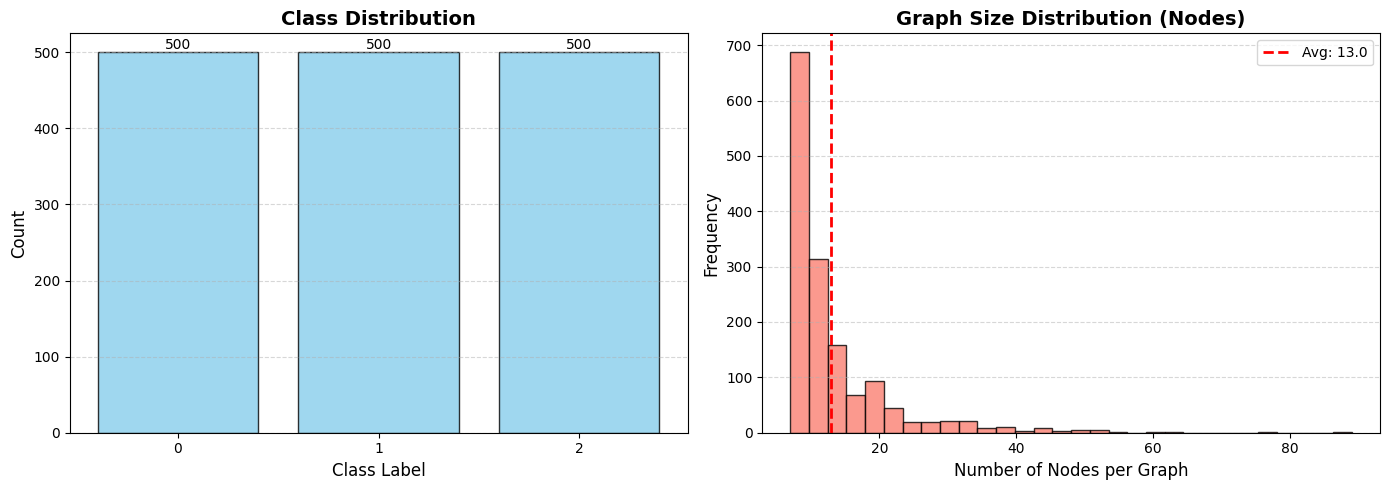

[Visuals] Saved extended dataset info to dataset_info.png
Dataset Features: 89 (Input Dimension)
Starting Main Experiment (10-Fold CV)...

STARTING FOLD 1/10
[Elapsed: 0:00:07] [RAM: 920.9 MB] --- Fold 1: Initializing GIN ---
[Elapsed: 0:00:08] [RAM: 1035.4 MB] Starting Training Loop...
[Elapsed: 0:00:31] [RAM: 1464.0 MB] Epoch 010 | Train: 1.6365 | Val: 1.7108 (Acc: 0.4467)
[Elapsed: 0:00:41] [RAM: 1464.1 MB] Epoch 020 | Train: 1.0384 | Val: 3.2217 (Acc: 0.4733)
[Elapsed: 0:00:51] [RAM: 1464.2 MB] Epoch 030 | Train: 1.0058 | Val: 1.1421 (Acc: 0.3933)
[Elapsed: 0:01:00] [RAM: 1464.3 MB] Epoch 040 | Train: 0.9516 | Val: 1.7920 (Acc: 0.4133)
[Elapsed: 0:01:09] [RAM: 1464.4 MB] Epoch 050 | Train: 1.0103 | Val: 2.9498 (Acc: 0.4000)
[Elapsed: 0:01:19] [RAM: 1464.4 MB] Epoch 060 | Train: 0.9250 | Val: 1.8422 (Acc: 0.4733)
[Elapsed: 0:01:29] [RAM: 1464.5 MB] Epoch 070 | Train: 0.9090 | Val: 2.1011 (Acc: 0.4667)
[Elapsed: 0:01:39] [RAM: 1464.5 MB] Epoch 080 | Train: 0.8940 | Val: 11.7231 (Acc:

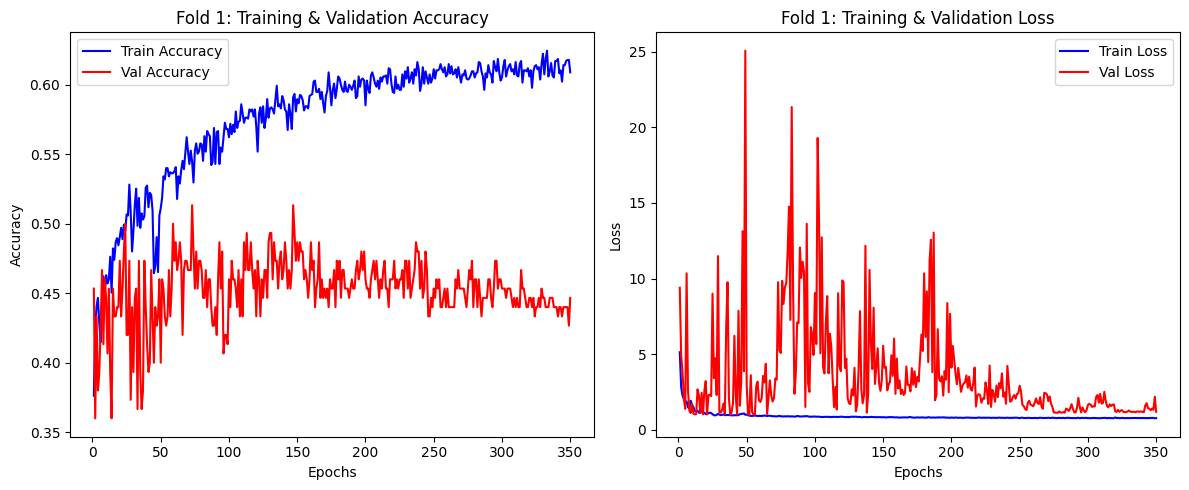

[Elapsed: 0:06:03] [RAM: 1478.2 MB] Loading 'embeddings_fold_1.npz' for Evaluation...

   [Fold 1 Evaluation]
   Model      | Acc      | F1       | AUC      | Time(s) 
   ------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


   SVM_Lin    | 36.7%   | 25.1%   | 0.617    | 0.59s
   SVM_RBF    | 44.0%   | 42.0%   | 0.629    | 0.68s
   RF         | 48.7%   | 48.1%   | 0.628    | 0.78s
   MLP        | 42.7%   | 41.0%   | 0.597    | 2.18s
   >> KMeans ARI: -0.0001
   >> Spectral ARI: 0.0293

Computing t-SNE for cluster comparison...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


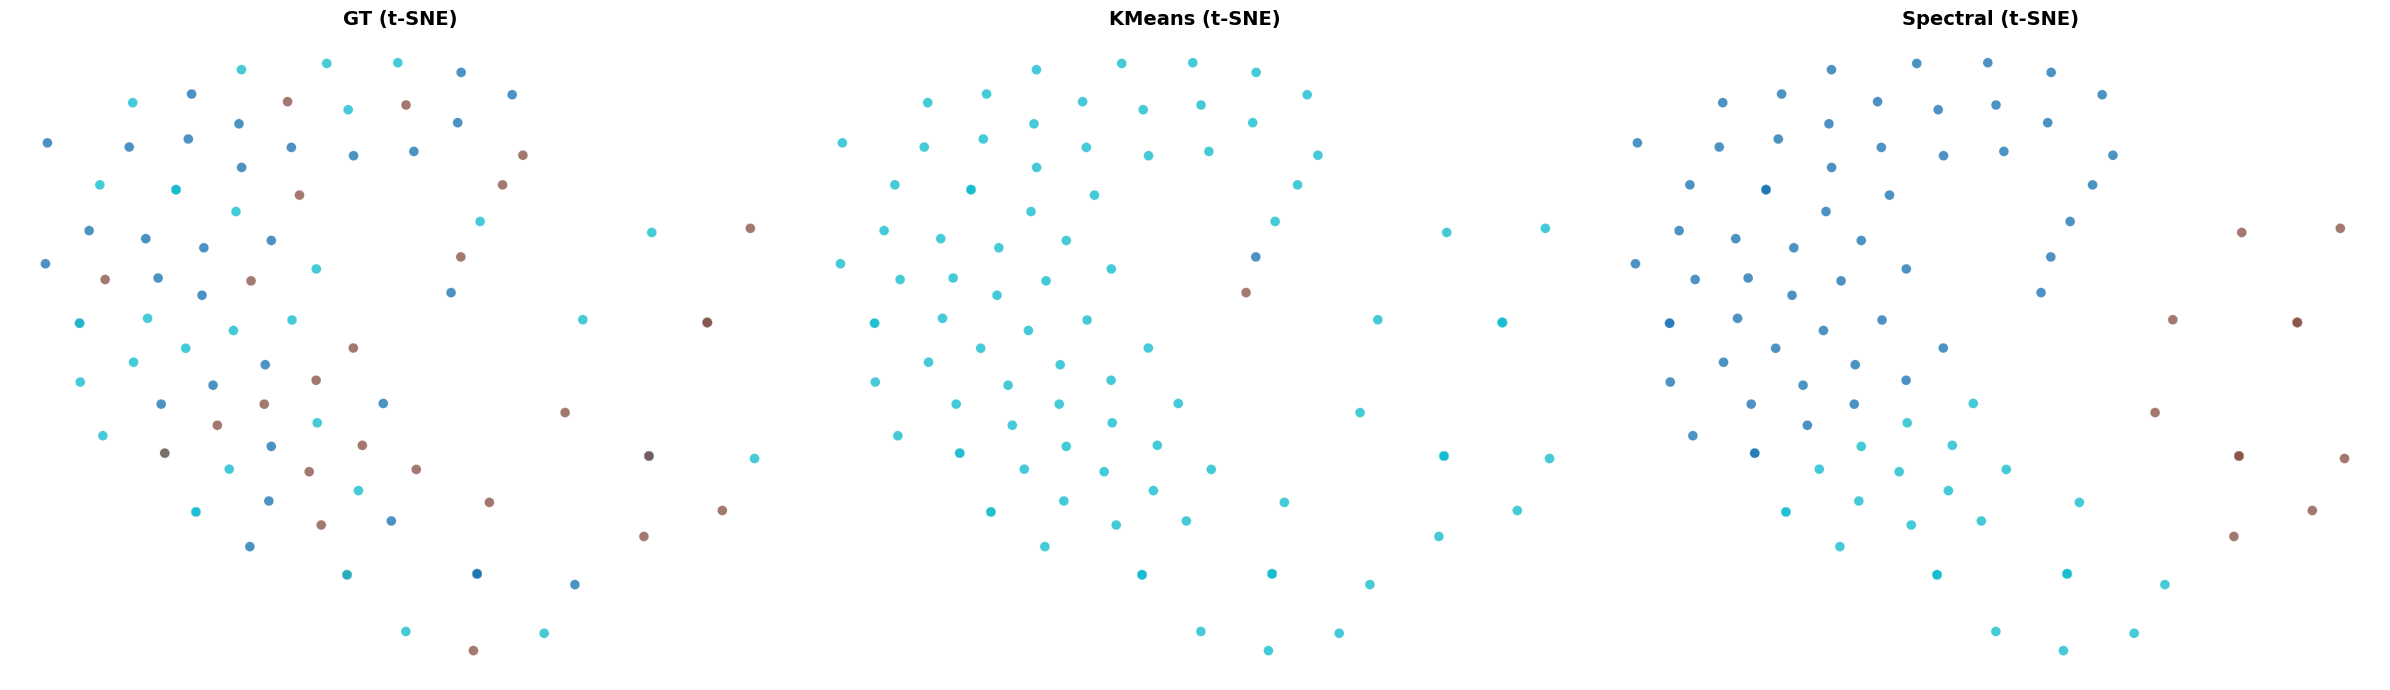

[Visuals] Saved 3-panel cluster comparison to pca_cluster_comparison_fold_1.png
>> Running Stability Analysis for Fold 1...

>> ] Running Analysis for Fold 1...
   > Clean Baseline Acc: 47.33%
[Elapsed: 0:06:09] [RAM: 1496.2 MB] Perturb Dataset...
[Elapsed: 0:06:09] [RAM: 1496.8 MB] Perturb Dataset...
[Elapsed: 0:06:09] [RAM: 1496.9 MB] Perturb Dataset...
[Elapsed: 0:06:09] [RAM: 1496.9 MB] Perturb Dataset...
[Elapsed: 0:06:09] [RAM: 1497.0 MB] Perturb Dataset...
[Elapsed: 0:06:10] [RAM: 1497.0 MB] Perturb Dataset...
[Elapsed: 0:06:10] [RAM: 1497.0 MB] Perturb Dataset...
[Elapsed: 0:06:10] [RAM: 1497.0 MB] Perturb Dataset...

   [Fold 1 Stability Report]
   Mode       | Noise    | Acc      | CosSim  
   ----------------------------------------
   Clean      | 0%       | 0.4733   | 1.0000
   add        | 5%      | 0.4667   | 0.9989
   add        | 10%      | 0.4667   | 0.9977
   add        | 15%      | 0.4600   | 0.9970
   add        | 20%      | 0.4267   | 0.9966
   remove     | 5%    

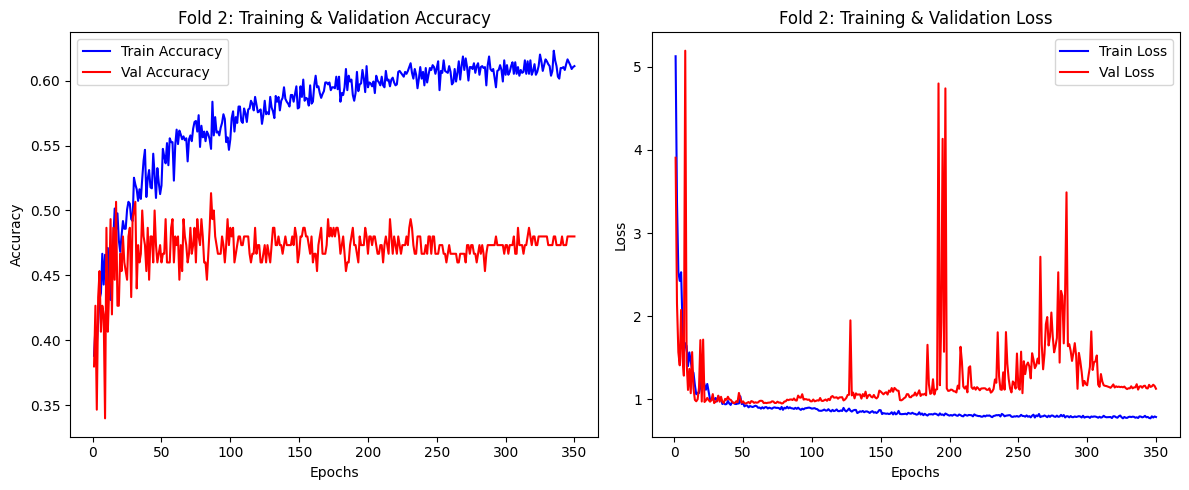

[Elapsed: 0:11:58] [RAM: 1498.7 MB] Loading 'embeddings_fold_2.npz' for Evaluation...

   [Fold 2 Evaluation]
   Model      | Acc      | F1       | AUC      | Time(s) 
   ------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


   SVM_Lin    | 34.0%   | 23.0%   | 0.541    | 0.52s
   SVM_RBF    | 31.3%   | 30.6%   | 0.487    | 0.69s
   RF         | 45.3%   | 44.4%   | 0.652    | 0.80s
   MLP        | 31.3%   | 31.0%   | 0.502    | 1.00s
   >> KMeans ARI: -0.0021
   >> Spectral ARI: -0.0034

>> Running Stability Analysis for Fold 2...

>> ] Running Analysis for Fold 2...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   > Clean Baseline Acc: 46.67%
[Elapsed: 0:12:01] [RAM: 1498.7 MB] Perturb Dataset...
[Elapsed: 0:12:01] [RAM: 1498.7 MB] Perturb Dataset...
[Elapsed: 0:12:02] [RAM: 1498.7 MB] Perturb Dataset...
[Elapsed: 0:12:02] [RAM: 1498.7 MB] Perturb Dataset...
[Elapsed: 0:12:02] [RAM: 1498.7 MB] Perturb Dataset...
[Elapsed: 0:12:02] [RAM: 1498.7 MB] Perturb Dataset...
[Elapsed: 0:12:02] [RAM: 1498.7 MB] Perturb Dataset...
[Elapsed: 0:12:02] [RAM: 1498.7 MB] Perturb Dataset...

   [Fold 2 Stability Report]
   Mode       | Noise    | Acc      | CosSim  
   ----------------------------------------
   Clean      | 0%       | 0.4667   | 1.0000
   add        | 5%      | 0.4667   | 0.9999
   add        | 10%      | 0.4800   | 0.9993
   add        | 15%      | 0.4533   | 0.9984
   add        | 20%      | 0.4600   | 0.9979
   remove     | 5%      | 0.5067   | 0.9999
   remove     | 10%      | 0.5200   | 0.9993
   remove     | 15%      | 0.5133   | 0.9986
   remove     | 20%      | 0.5067   | 0.9984
   -

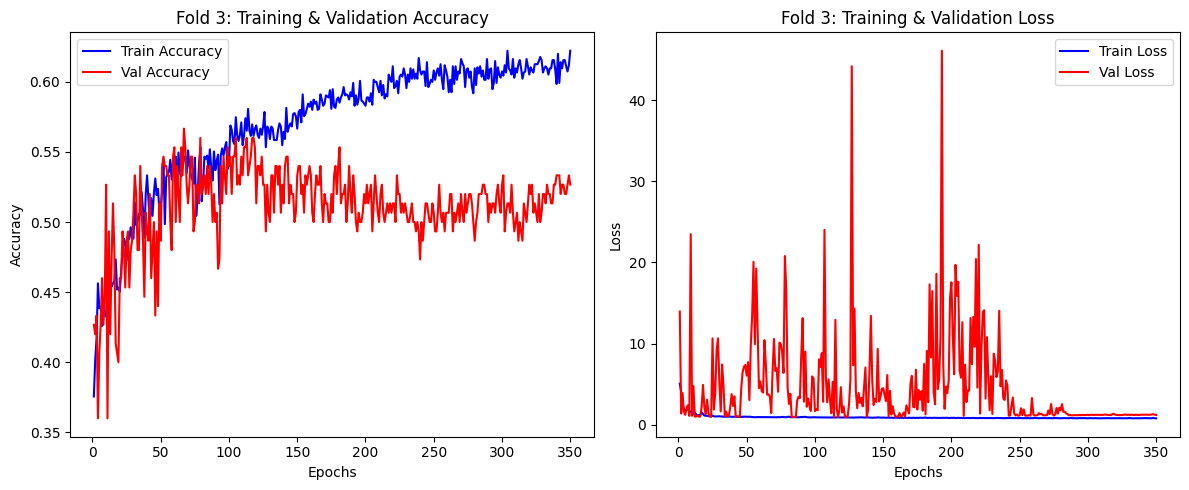

[Elapsed: 0:17:55] [RAM: 1498.8 MB] Loading 'embeddings_fold_3.npz' for Evaluation...

   [Fold 3 Evaluation]
   Model      | Acc      | F1       | AUC      | Time(s) 
   ------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


   SVM_Lin    | 39.3%   | 29.4%   | 0.638    | 0.60s
   SVM_RBF    | 37.3%   | 37.4%   | 0.554    | 0.67s
   RF         | 51.3%   | 51.3%   | 0.713    | 0.81s
   MLP        | 36.7%   | 36.9%   | 0.534    | 1.22s
   >> KMeans ARI: 0.0139
   >> Spectral ARI: 0.0061

>> Running Stability Analysis for Fold 3...

>> ] Running Analysis for Fold 3...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   > Clean Baseline Acc: 56.00%
[Elapsed: 0:17:59] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:17:59] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:17:59] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:17:59] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:17:59] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:17:59] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:17:59] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:17:59] [RAM: 1498.8 MB] Perturb Dataset...

   [Fold 3 Stability Report]
   Mode       | Noise    | Acc      | CosSim  
   ----------------------------------------
   Clean      | 0%       | 0.5600   | 1.0000
   add        | 5%      | 0.5533   | 1.0000
   add        | 10%      | 0.5533   | 1.0000
   add        | 15%      | 0.5400   | 1.0000
   add        | 20%      | 0.5467   | 0.9987
   remove     | 5%      | 0.5333   | 1.0000
   remove     | 10%      | 0.5267   | 0.9997
   remove     | 15%      | 0.5467   | 0.9980
   remove     | 20%      | 0.5333   | 0.9966
   -

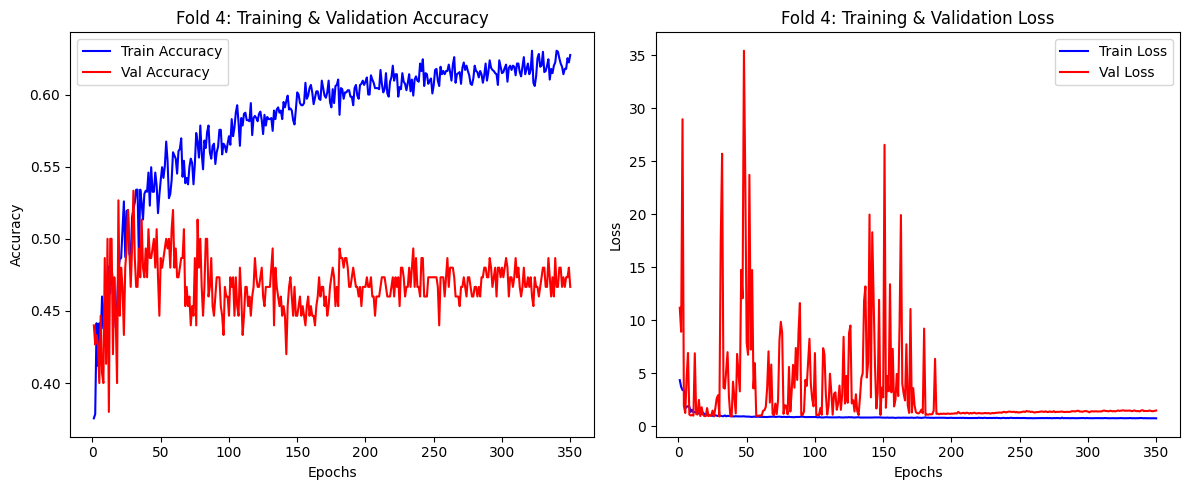

[Elapsed: 0:23:52] [RAM: 1498.8 MB] Loading 'embeddings_fold_4.npz' for Evaluation...

   [Fold 4 Evaluation]
   Model      | Acc      | F1       | AUC      | Time(s) 
   ------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


   SVM_Lin    | 38.0%   | 28.1%   | 0.589    | 0.75s
   SVM_RBF    | 37.3%   | 35.6%   | 0.547    | 0.70s
   RF         | 44.7%   | 43.1%   | 0.656    | 0.81s
   MLP        | 40.0%   | 39.1%   | 0.579    | 2.07s
   >> KMeans ARI: 0.0007
   >> Spectral ARI: -0.0036

>> Running Stability Analysis for Fold 4...

>> ] Running Analysis for Fold 4...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   > Clean Baseline Acc: 53.33%
[Elapsed: 0:23:57] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:23:57] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:23:57] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:23:57] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:23:57] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:23:57] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:23:58] [RAM: 1498.8 MB] Perturb Dataset...
[Elapsed: 0:23:58] [RAM: 1498.8 MB] Perturb Dataset...

   [Fold 4 Stability Report]
   Mode       | Noise    | Acc      | CosSim  
   ----------------------------------------
   Clean      | 0%       | 0.5333   | 1.0000
   add        | 5%      | 0.5533   | 1.0000
   add        | 10%      | 0.5533   | 1.0000
   add        | 15%      | 0.5467   | 0.9999
   add        | 20%      | 0.5600   | 0.9999
   remove     | 5%      | 0.5333   | 1.0000
   remove     | 10%      | 0.5267   | 0.9994
   remove     | 15%      | 0.5267   | 0.9984
   remove     | 20%      | 0.4867   | 0.9979
   -

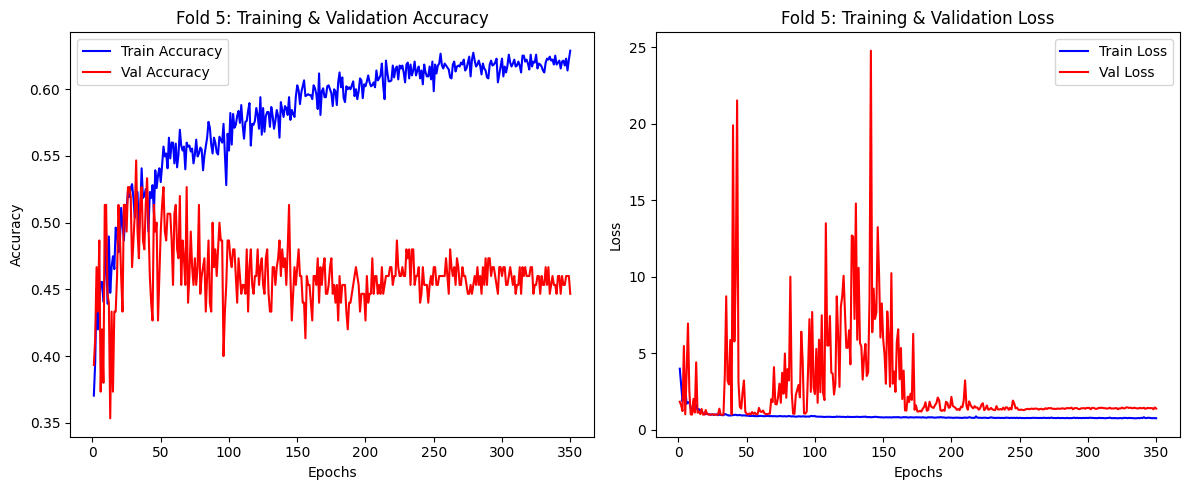

[Elapsed: 0:29:51] [RAM: 1498.9 MB] Loading 'embeddings_fold_5.npz' for Evaluation...

   [Fold 5 Evaluation]
   Model      | Acc      | F1       | AUC      | Time(s) 
   ------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


   SVM_Lin    | 35.3%   | 23.7%   | 0.572    | 0.59s
   SVM_RBF    | 27.3%   | 25.6%   | 0.503    | 1.06s
   RF         | 46.7%   | 44.6%   | 0.614    | 1.30s
   MLP        | 42.0%   | 38.8%   | 0.622    | 3.70s
   >> KMeans ARI: 0.0030
   >> Spectral ARI: -0.0004

>> Running Stability Analysis for Fold 5...

>> ] Running Analysis for Fold 5...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   > Clean Baseline Acc: 52.67%
[Elapsed: 0:29:58] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:29:58] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:29:58] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:29:58] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:29:58] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:29:58] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:29:58] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:29:59] [RAM: 1498.9 MB] Perturb Dataset...

   [Fold 5 Stability Report]
   Mode       | Noise    | Acc      | CosSim  
   ----------------------------------------
   Clean      | 0%       | 0.5267   | 1.0000
   add        | 5%      | 0.5200   | 0.9999
   add        | 10%      | 0.5200   | 0.9997
   add        | 15%      | 0.5133   | 0.9985
   add        | 20%      | 0.5333   | 0.9966
   remove     | 5%      | 0.5067   | 1.0000
   remove     | 10%      | 0.5067   | 0.9999
   remove     | 15%      | 0.5333   | 0.9998
   remove     | 20%      | 0.4733   | 0.9997
   -

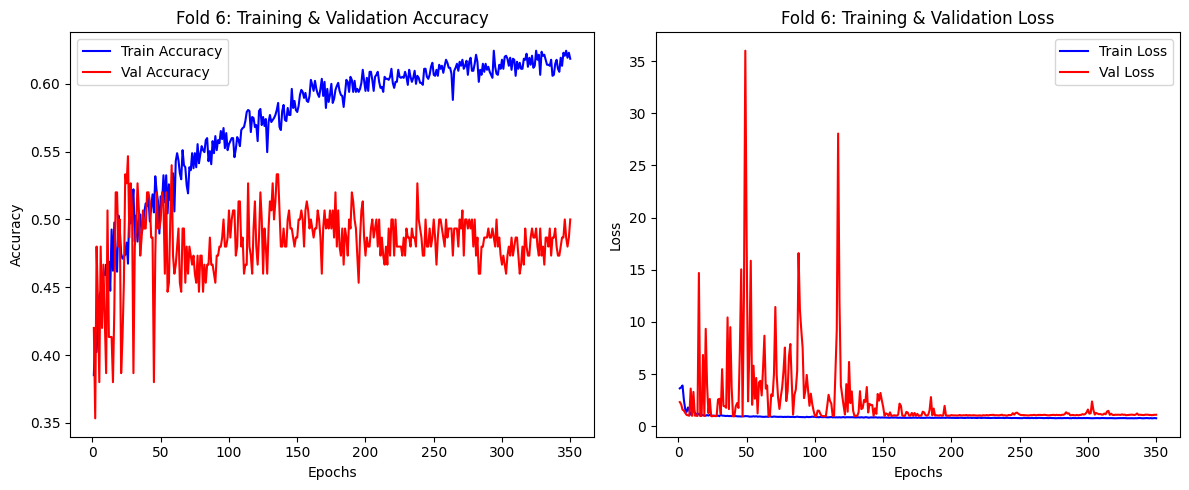

[Elapsed: 0:35:46] [RAM: 1498.9 MB] Loading 'embeddings_fold_6.npz' for Evaluation...

   [Fold 6 Evaluation]
   Model      | Acc      | F1       | AUC      | Time(s) 
   ------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


   SVM_Lin    | 47.3%   | 41.4%   | 0.686    | 0.61s
   SVM_RBF    | 44.7%   | 42.3%   | 0.641    | 0.66s
   RF         | 46.7%   | 43.9%   | 0.668    | 0.78s
   MLP        | 50.7%   | 47.3%   | 0.693    | 2.20s
   >> KMeans ARI: 0.0002
   >> Spectral ARI: 0.0218

>> Running Stability Analysis for Fold 6...

>> ] Running Analysis for Fold 6...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   > Clean Baseline Acc: 48.67%
[Elapsed: 0:35:50] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:35:50] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:35:50] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:35:51] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:35:51] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:35:51] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:35:51] [RAM: 1498.9 MB] Perturb Dataset...
[Elapsed: 0:35:51] [RAM: 1498.9 MB] Perturb Dataset...

   [Fold 6 Stability Report]
   Mode       | Noise    | Acc      | CosSim  
   ----------------------------------------
   Clean      | 0%       | 0.4867   | 1.0000
   add        | 5%      | 0.5000   | 0.9994
   add        | 10%      | 0.5133   | 0.9986
   add        | 15%      | 0.5133   | 0.9981
   add        | 20%      | 0.5000   | 0.9977
   remove     | 5%      | 0.4933   | 0.9998
   remove     | 10%      | 0.5000   | 0.9993
   remove     | 15%      | 0.4800   | 0.9979
   remove     | 20%      | 0.4867   | 0.9947
   -

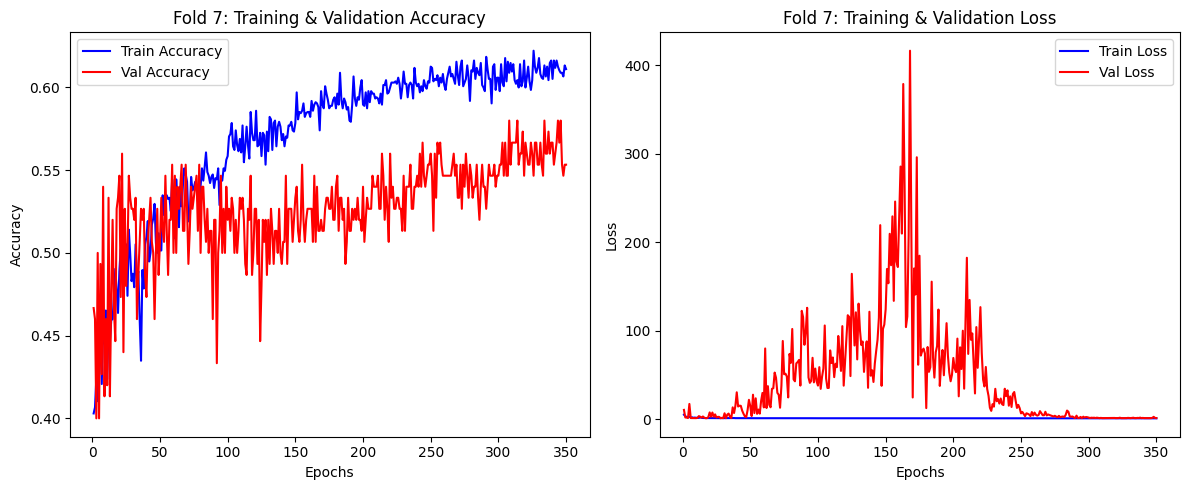

[Elapsed: 0:41:39] [RAM: 1499.0 MB] Loading 'embeddings_fold_7.npz' for Evaluation...

   [Fold 7 Evaluation]
   Model      | Acc      | F1       | AUC      | Time(s) 
   ------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


   SVM_Lin    | 38.0%   | 33.9%   | 0.527    | 0.51s
   SVM_RBF    | 34.7%   | 33.1%   | 0.506    | 0.63s
   RF         | 53.3%   | 52.3%   | 0.705    | 0.81s
   MLP        | 39.3%   | 38.4%   | 0.586    | 3.25s
   >> KMeans ARI: -0.0024
   >> Spectral ARI: 0.0180

>> Running Stability Analysis for Fold 7...

>> ] Running Analysis for Fold 7...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   > Clean Baseline Acc: 53.33%
[Elapsed: 0:41:45] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:41:45] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:41:45] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:41:45] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:41:45] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:41:45] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:41:45] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:41:45] [RAM: 1499.0 MB] Perturb Dataset...

   [Fold 7 Stability Report]
   Mode       | Noise    | Acc      | CosSim  
   ----------------------------------------
   Clean      | 0%       | 0.5333   | 1.0000
   add        | 5%      | 0.5333   | 1.0000
   add        | 10%      | 0.5067   | 0.9995
   add        | 15%      | 0.5200   | 0.9990
   add        | 20%      | 0.5200   | 0.9987
   remove     | 5%      | 0.5400   | 1.0000
   remove     | 10%      | 0.5267   | 0.9999
   remove     | 15%      | 0.5467   | 0.9998
   remove     | 20%      | 0.5467   | 0.9993
   -

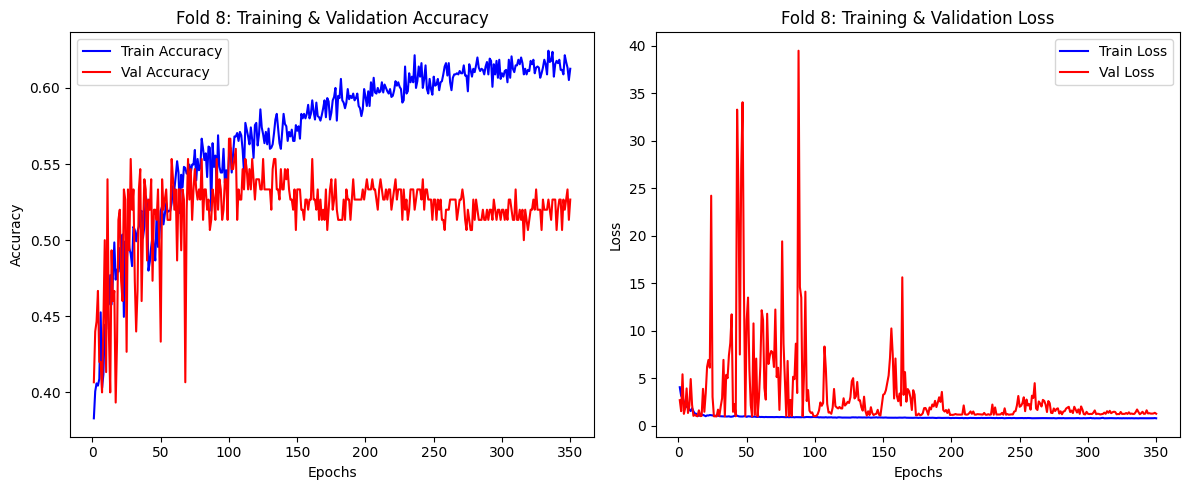

[Elapsed: 0:47:29] [RAM: 1499.0 MB] Loading 'embeddings_fold_8.npz' for Evaluation...

   [Fold 8 Evaluation]
   Model      | Acc      | F1       | AUC      | Time(s) 
   ------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


   SVM_Lin    | 52.0%   | 47.7%   | 0.678    | 0.57s
   SVM_RBF    | 43.3%   | 42.1%   | 0.556    | 1.08s
   RF         | 54.0%   | 51.7%   | 0.697    | 1.46s
   MLP        | 53.3%   | 48.5%   | 0.725    | 3.30s
   >> KMeans ARI: 0.0018
   >> Spectral ARI: 0.0237

>> Running Stability Analysis for Fold 8...

>> ] Running Analysis for Fold 8...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   > Clean Baseline Acc: 53.33%
[Elapsed: 0:47:36] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:47:36] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:47:37] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:47:37] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:47:37] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:47:37] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:47:37] [RAM: 1499.0 MB] Perturb Dataset...
[Elapsed: 0:47:37] [RAM: 1499.0 MB] Perturb Dataset...

   [Fold 8 Stability Report]
   Mode       | Noise    | Acc      | CosSim  
   ----------------------------------------
   Clean      | 0%       | 0.5333   | 1.0000
   add        | 5%      | 0.5267   | 1.0000
   add        | 10%      | 0.5400   | 0.9997
   add        | 15%      | 0.5667   | 0.9992
   add        | 20%      | 0.5333   | 0.9987
   remove     | 5%      | 0.5400   | 1.0000
   remove     | 10%      | 0.5267   | 0.9999
   remove     | 15%      | 0.5400   | 0.9998
   remove     | 20%      | 0.5533   | 0.9996
   -

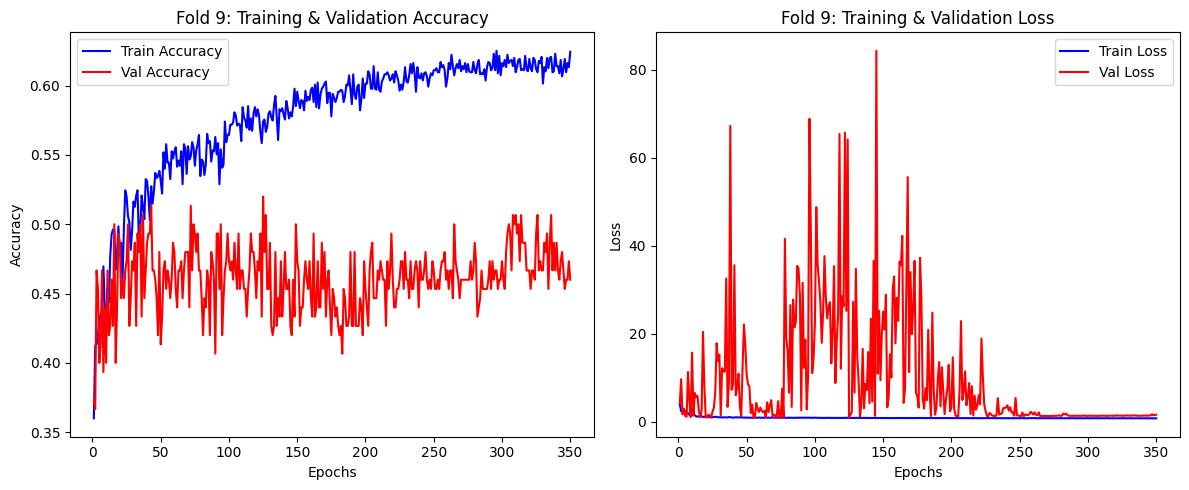

[Elapsed: 0:53:27] [RAM: 1499.1 MB] Loading 'embeddings_fold_9.npz' for Evaluation...

   [Fold 9 Evaluation]
   Model      | Acc      | F1       | AUC      | Time(s) 
   ------------------------------------------------------------
   SVM_Lin    | 40.0%   | 32.5%   | 0.618    | 0.54s
   SVM_RBF    | 40.7%   | 39.8%   | 0.592    | 0.71s
   RF         | 46.0%   | 45.9%   | 0.634    | 0.83s
   MLP        | 46.7%   | 46.5%   | 0.697    | 3.50s
   >> KMeans ARI: 0.0002
   >> Spectral ARI: 0.0042

>> Running Stability Analysis for Fold 9...

>> ] Running Analysis for Fold 9...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   > Clean Baseline Acc: 48.67%
[Elapsed: 0:53:34] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:53:34] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:53:34] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:53:34] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:53:34] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:53:34] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:53:34] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:53:34] [RAM: 1499.1 MB] Perturb Dataset...

   [Fold 9 Stability Report]
   Mode       | Noise    | Acc      | CosSim  
   ----------------------------------------
   Clean      | 0%       | 0.4867   | 1.0000
   add        | 5%      | 0.4867   | 0.9999
   add        | 10%      | 0.5000   | 0.9998
   add        | 15%      | 0.4800   | 0.9996
   add        | 20%      | 0.4667   | 0.9994
   remove     | 5%      | 0.4867   | 0.9999
   remove     | 10%      | 0.5000   | 0.9998
   remove     | 15%      | 0.4933   | 0.9996
   remove     | 20%      | 0.5133   | 0.9992
   -

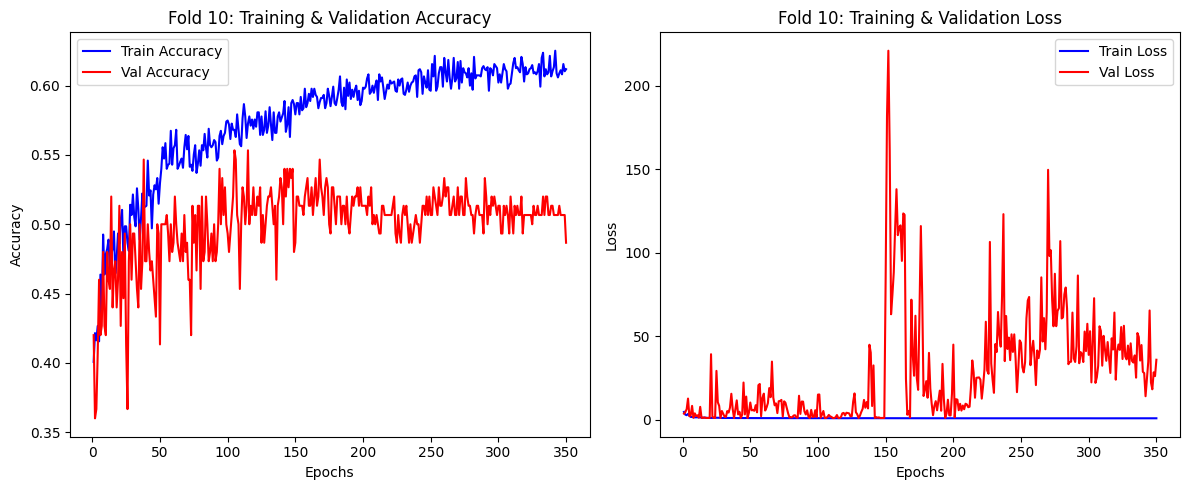

[Elapsed: 0:59:23] [RAM: 1499.1 MB] Loading 'embeddings_fold_10.npz' for Evaluation...

   [Fold 10 Evaluation]
   Model      | Acc      | F1       | AUC      | Time(s) 
   ------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


   SVM_Lin    | 38.0%   | 28.3%   | 0.554    | 0.61s
   SVM_RBF    | 39.3%   | 38.7%   | 0.566    | 0.73s
   RF         | 50.7%   | 50.2%   | 0.711    | 0.80s
   MLP        | 44.0%   | 43.8%   | 0.606    | 1.81s
   >> KMeans ARI: 0.0005
   >> Spectral ARI: 0.0012

>> Running Stability Analysis for Fold 10...

>> ] Running Analysis for Fold 10...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   > Clean Baseline Acc: 52.67%
[Elapsed: 0:59:28] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:59:28] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:59:28] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:59:28] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:59:28] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:59:28] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:59:28] [RAM: 1499.1 MB] Perturb Dataset...
[Elapsed: 0:59:28] [RAM: 1499.1 MB] Perturb Dataset...

   [Fold 10 Stability Report]
   Mode       | Noise    | Acc      | CosSim  
   ----------------------------------------
   Clean      | 0%       | 0.5267   | 1.0000
   add        | 5%      | 0.5333   | 0.9995
   add        | 10%      | 0.5267   | 0.9963
   add        | 15%      | 0.5067   | 0.9941
   add        | 20%      | 0.5133   | 0.9931
   remove     | 5%      | 0.5133   | 0.9999
   remove     | 10%      | 0.4933   | 0.9991
   remove     | 15%      | 0.5267   | 0.9933
   remove     | 20%      | 0.4733   | 0.9860
   

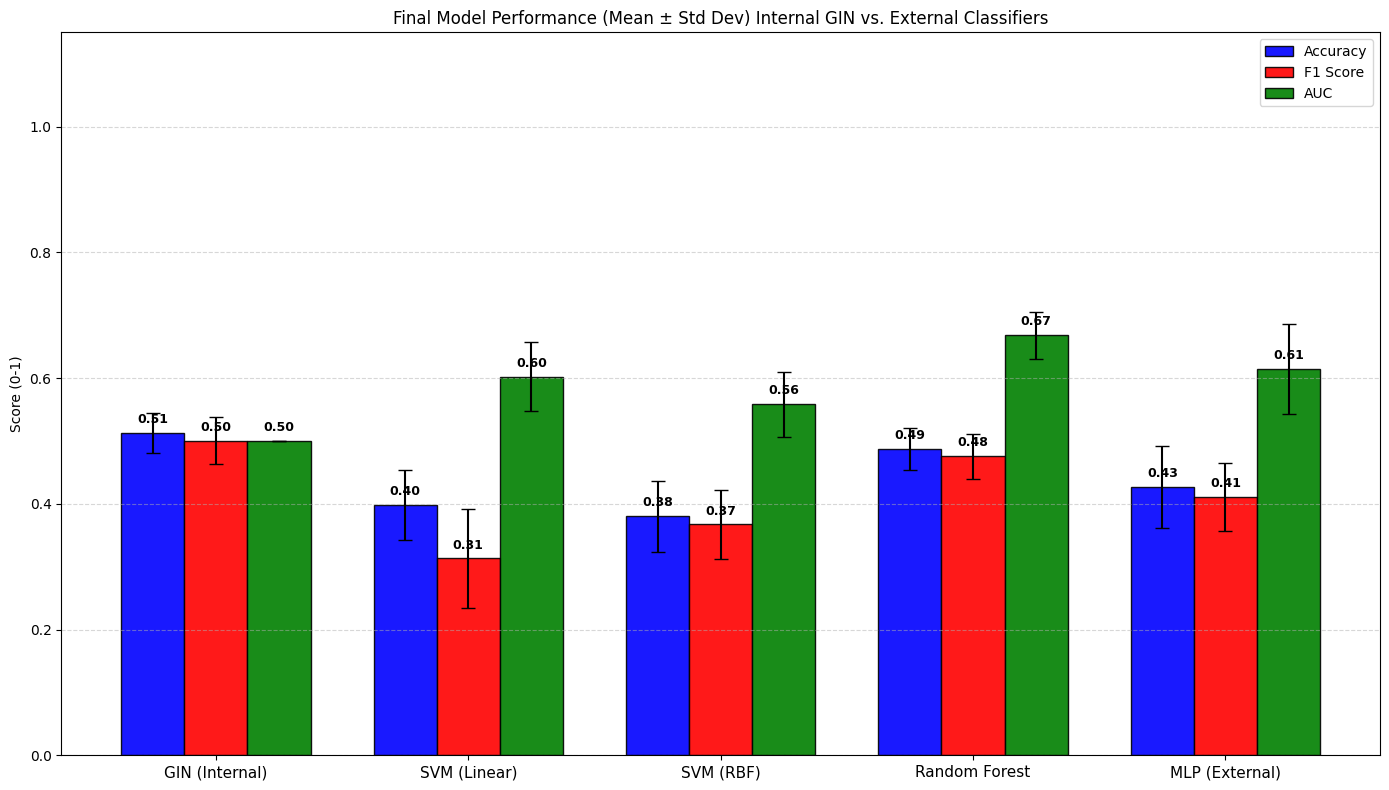

[Visuals] Saved final summary to final_performance.png


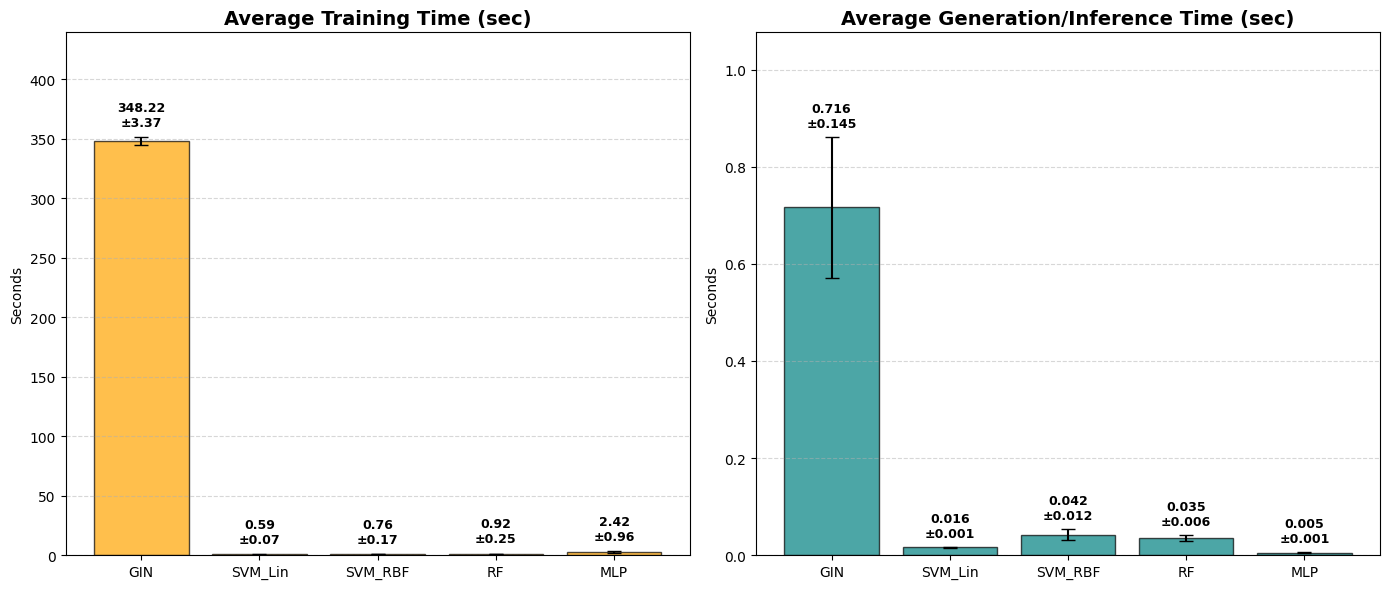

[Visuals] Saved resource usage report to resource_usage.png

      RESOURCE CONSUMPTION REPORT (Mean ± Std)
Method     | Train Time (s)       | Gen Time (s)         | Peak RAM (MB)  
---------------------------------------------------------------------------
GIN        | 348.22 ± 3.37        | 0.72 ± 0.15          | 0.48 ± 0.01    
SVM_Lin    | 0.59 ± 0.07          | 0.02 ± 0.00          | -
SVM_RBF    | 0.76 ± 0.17          | 0.04 ± 0.01          | -
RF         | 0.92 ± 0.25          | 0.03 ± 0.01          | -
MLP        | 2.42 ± 0.96          | 0.01 ± 0.00          | -


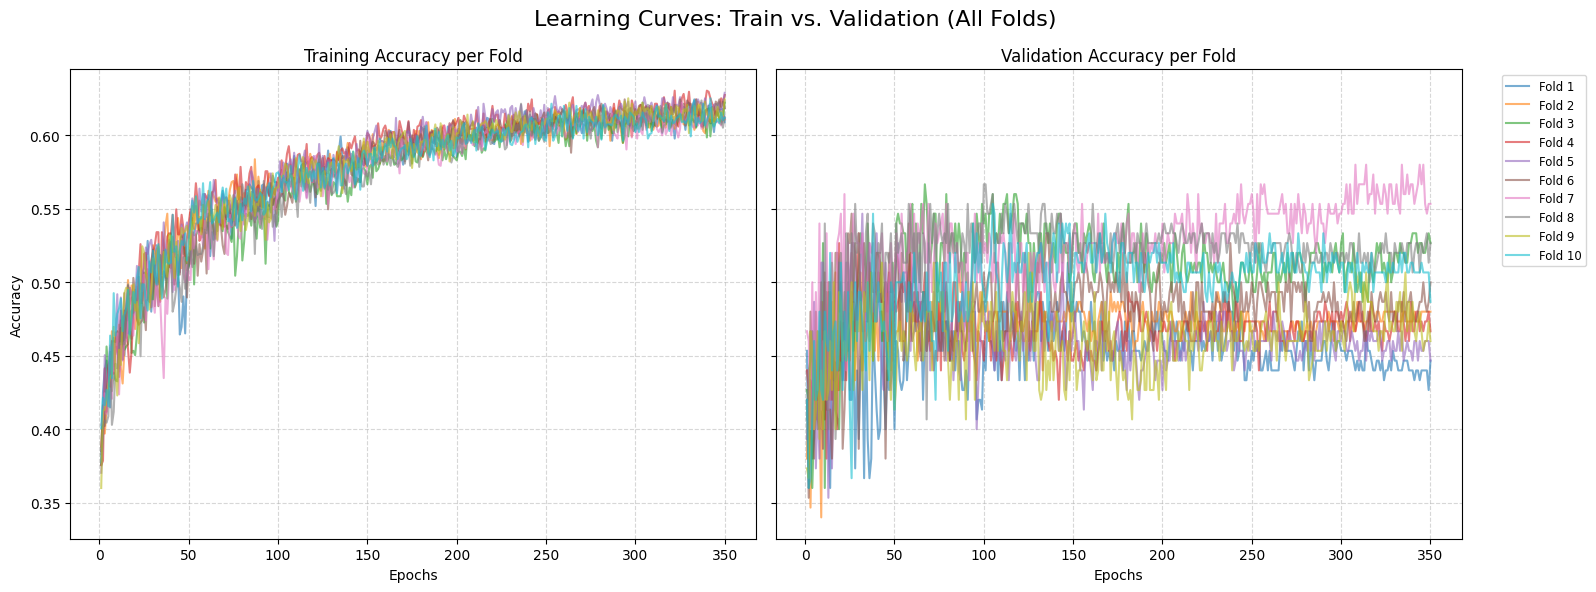

[Visuals] Saved training curves: fold_training_curves.png


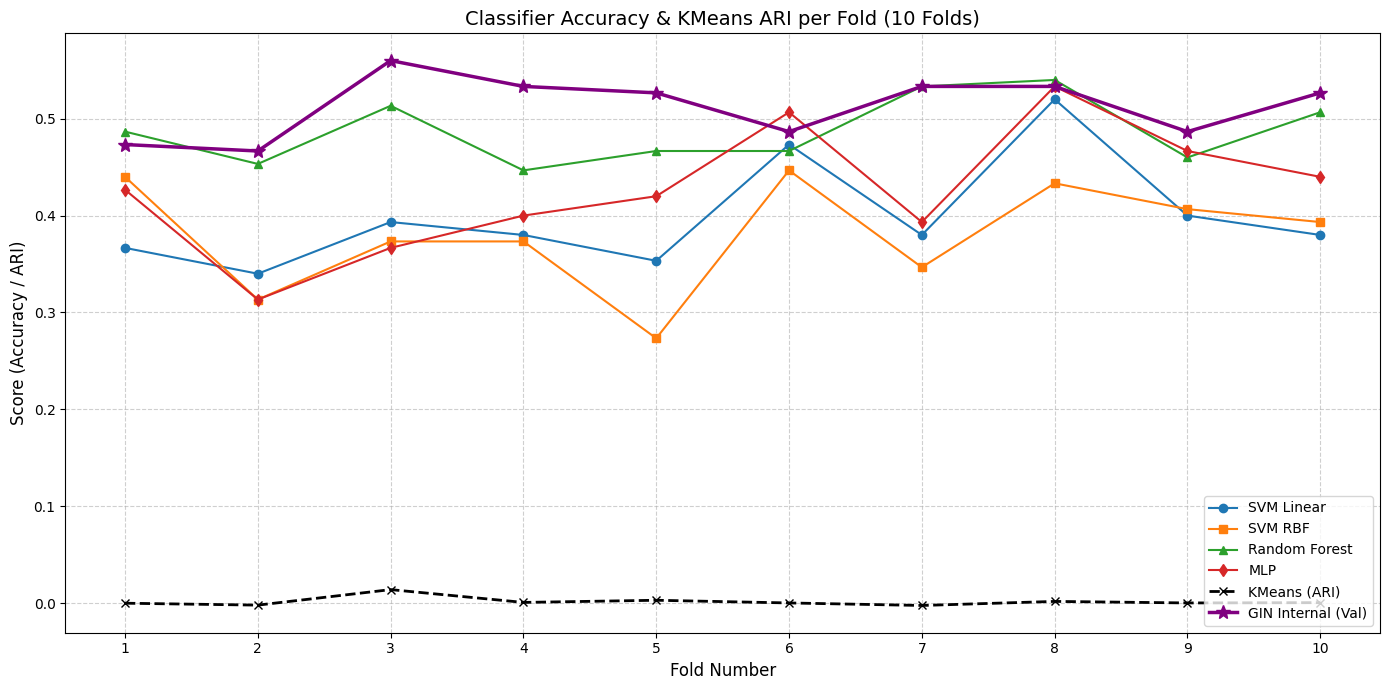

[Visuals] Saved fold performance plot: fold_performance.png
>> Generating Dual Stability Summary Plot to final_stability_bar_chart.png...
!! WARNING: stability_detailed_ALL_FOLDS.csv not found. Cannot plot Cosine Similarity.

>> Merging detailed stability reports...
[Data] Saved master stability file: stability_detailed_ALL_FOLDS.csv
>> Generating Robustness Curve for Model_Accuracy...


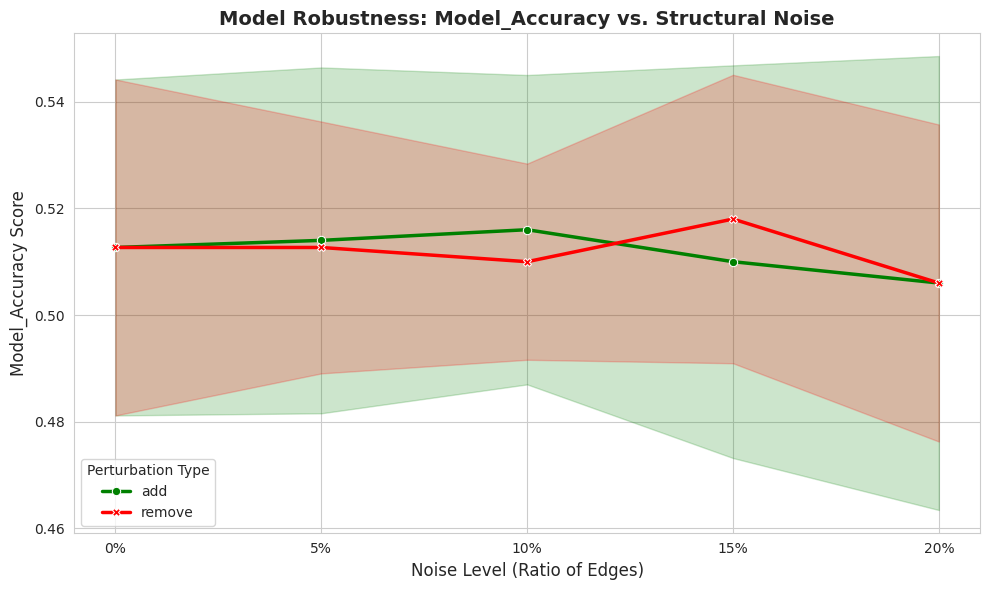

[Plots] Saved robustness curve to robustness_model_acc.png
>> Generating Robustness Curve for Cosine_Similarity...


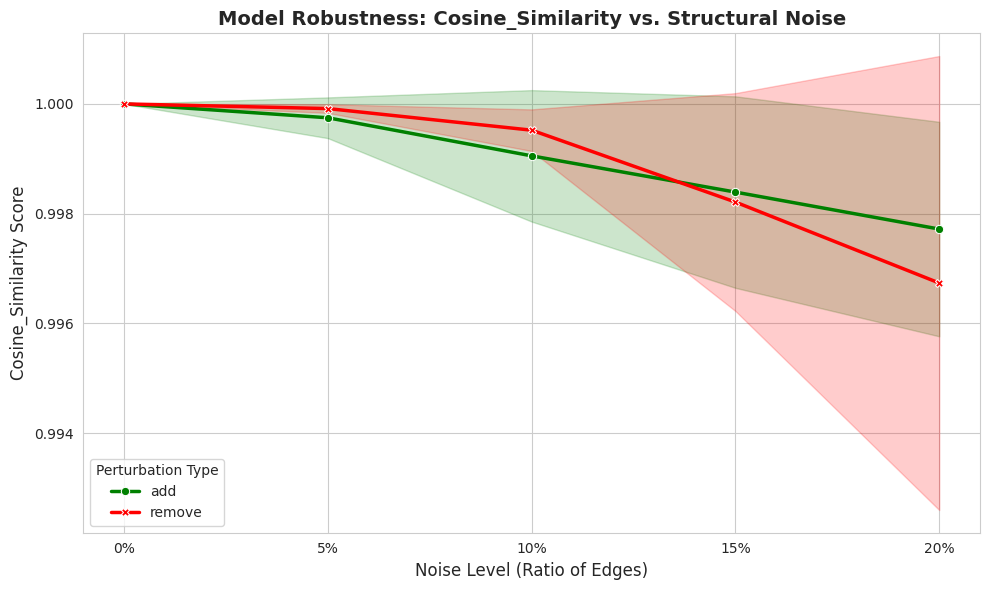

[Plots] Saved robustness curve to robustness_cosine_sim.png

Pipeline Finished in 59.56 minutes.


In [ ]:
# ==============================================================================
# CONFIGURATION
# ==============================================================================
DATASET_NAME = 'IMDB-MULTI'
run_pipeline(run_dataset_analysis=True, run_main_experiment=True, enable_stability=True, run_hyperparameter_tuning=False, n_folds=10)

In [ ]:
!zip -r /content/imdbsteplr64.zip /content/*.npz /content/*.csv /content/*.png /content/*.json /content/*.pth

  adding: content/embeddings_fold_10.npz (deflated 65%)
  adding: content/embeddings_fold_1.npz (deflated 63%)
  adding: content/embeddings_fold_2.npz (deflated 63%)
  adding: content/embeddings_fold_3.npz (deflated 63%)
  adding: content/embeddings_fold_4.npz (deflated 63%)
  adding: content/embeddings_fold_5.npz (deflated 63%)
  adding: content/embeddings_fold_6.npz (deflated 64%)
  adding: content/embeddings_fold_7.npz (deflated 63%)
  adding: content/embeddings_fold_8.npz (deflated 63%)
  adding: content/embeddings_fold_9.npz (deflated 63%)
  adding: content/experiment_results.csv (deflated 62%)
  adding: content/stability_detailed_ALL_FOLDS.csv (deflated 72%)
  adding: content/stability_fold_10_detailed.csv (deflated 56%)
  adding: content/stability_fold_1_detailed.csv (deflated 56%)
  adding: content/stability_fold_2_detailed.csv (deflated 52%)
  adding: content/stability_fold_3_detailed.csv (deflated 54%)
  adding: content/stability_fold_4_detailed.csv (deflated 55%)
  adding: c

In [ ]:
from google.colab import files

files.download('imdbsteplr64.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

STARTING PIPELINE
Loading IMDB-MULTI with One-Hot Degree...

STARTING HYPERPARAMETER TUNING (Embedding Dimension)

»»» Testing Hidden Dimension: 16 «««
[Elapsed: 0:01:19] [RAM: 1455.4 MB] --- Fold 1000: Initializing GIN ---
[Elapsed: 0:01:19] [RAM: 1463.6 MB] Starting Training Loop...
[Elapsed: 0:01:30] [RAM: 1463.6 MB] Epoch 010 | Train: 1.0714 | Val: 1.2668 (Acc: 0.4167)
[Elapsed: 0:01:39] [RAM: 1463.7 MB] Epoch 020 | Train: 1.0032 | Val: 1.1492 (Acc: 0.4567)
[Elapsed: 0:01:49] [RAM: 1463.7 MB] Epoch 030 | Train: 0.9572 | Val: 1.2662 (Acc: 0.4600)
[Elapsed: 0:01:58] [RAM: 1463.7 MB] Epoch 040 | Train: 0.9210 | Val: 1.3563 (Acc: 0.4533)
[Elapsed: 0:02:08] [RAM: 1463.7 MB] Epoch 050 | Train: 0.8962 | Val: 1.6088 (Acc: 0.4567)
[Elapsed: 0:02:17] [RAM: 1463.7 MB] Epoch 060 | Train: 0.8949 | Val: 1.3196 (Acc: 0.4533)
[Elapsed: 0:02:26] [RAM: 1463.8 MB] Epoch 070 | Train: 0.8888 | Val: 1.3366 (Acc: 0.4733)
[Elapsed: 0:02:35] [RAM: 1463.8 MB] Epoch 080 | Train: 0.9013 | Val: 3.2407 (Acc: 0.

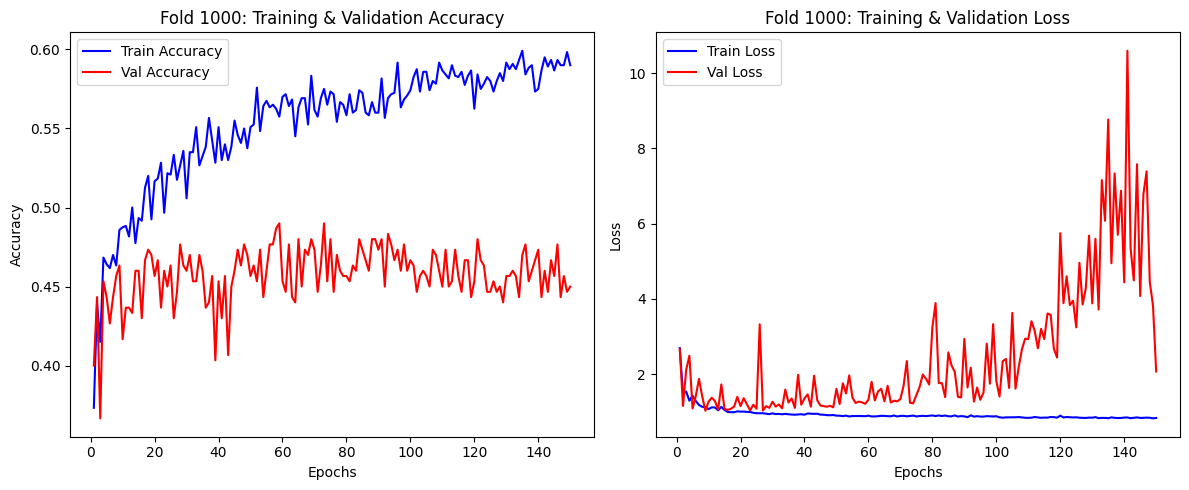


»»» Testing Hidden Dimension: 32 «««
[Elapsed: 0:03:43] [RAM: 1472.1 MB] --- Fold 1000: Initializing GIN ---
[Elapsed: 0:03:43] [RAM: 1473.8 MB] Starting Training Loop...
[Elapsed: 0:03:53] [RAM: 1487.2 MB] Epoch 010 | Train: 1.2838 | Val: 4.7951 (Acc: 0.4333)
[Elapsed: 0:04:02] [RAM: 1487.3 MB] Epoch 020 | Train: 1.0985 | Val: 1.0088 (Acc: 0.4667)
[Elapsed: 0:04:13] [RAM: 1487.3 MB] Epoch 030 | Train: 0.9377 | Val: 1.0094 (Acc: 0.4200)
[Elapsed: 0:04:22] [RAM: 1487.4 MB] Epoch 040 | Train: 0.9216 | Val: 1.0248 (Acc: 0.4333)
[Elapsed: 0:04:32] [RAM: 1487.4 MB] Epoch 050 | Train: 0.9599 | Val: 1.4909 (Acc: 0.4367)
[Elapsed: 0:04:42] [RAM: 1487.4 MB] Epoch 060 | Train: 0.8817 | Val: 1.5361 (Acc: 0.4700)
[Elapsed: 0:04:50] [RAM: 1487.4 MB] Epoch 070 | Train: 0.8734 | Val: 2.3901 (Acc: 0.4600)
[Elapsed: 0:05:00] [RAM: 1487.4 MB] Epoch 080 | Train: 0.8735 | Val: 3.6781 (Acc: 0.4633)
[Elapsed: 0:05:09] [RAM: 1487.5 MB] Epoch 090 | Train: 0.8504 | Val: 11.8731 (Acc: 0.4467)
[Elapsed: 0:05:19

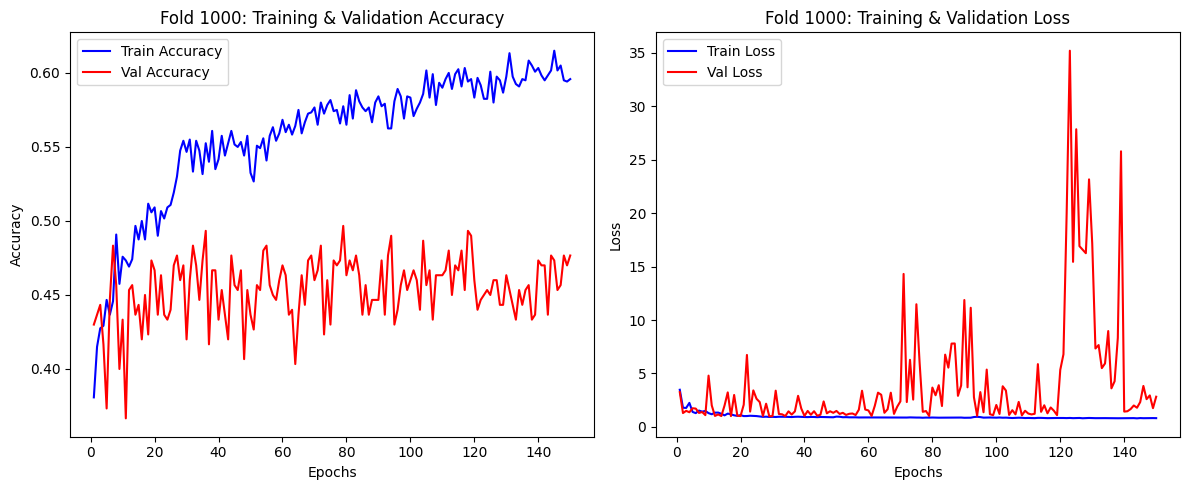


»»» Testing Hidden Dimension: 64 «««
[Elapsed: 0:06:07] [RAM: 1492.3 MB] --- Fold 1000: Initializing GIN ---
[Elapsed: 0:06:07] [RAM: 1493.0 MB] Starting Training Loop...
[Elapsed: 0:06:17] [RAM: 1493.3 MB] Epoch 010 | Train: 1.3999 | Val: 3.2695 (Acc: 0.4167)
[Elapsed: 0:06:26] [RAM: 1493.3 MB] Epoch 020 | Train: 1.0666 | Val: 1.0414 (Acc: 0.4833)
[Elapsed: 0:06:36] [RAM: 1493.3 MB] Epoch 030 | Train: 1.0021 | Val: 1.2414 (Acc: 0.4600)
[Elapsed: 0:06:45] [RAM: 1493.3 MB] Epoch 040 | Train: 0.9222 | Val: 0.9871 (Acc: 0.4633)
[Elapsed: 0:06:55] [RAM: 1493.3 MB] Epoch 050 | Train: 0.9331 | Val: 1.0069 (Acc: 0.4633)
[Elapsed: 0:07:04] [RAM: 1493.3 MB] Epoch 060 | Train: 0.8949 | Val: 1.0382 (Acc: 0.4767)
[Elapsed: 0:07:13] [RAM: 1493.3 MB] Epoch 070 | Train: 0.8746 | Val: 1.0136 (Acc: 0.4733)
[Elapsed: 0:07:23] [RAM: 1493.3 MB] Epoch 080 | Train: 0.8592 | Val: 4.5782 (Acc: 0.4633)
[Elapsed: 0:07:33] [RAM: 1493.3 MB] Epoch 090 | Train: 0.8733 | Val: 1.0688 (Acc: 0.4767)
[Elapsed: 0:07:42]

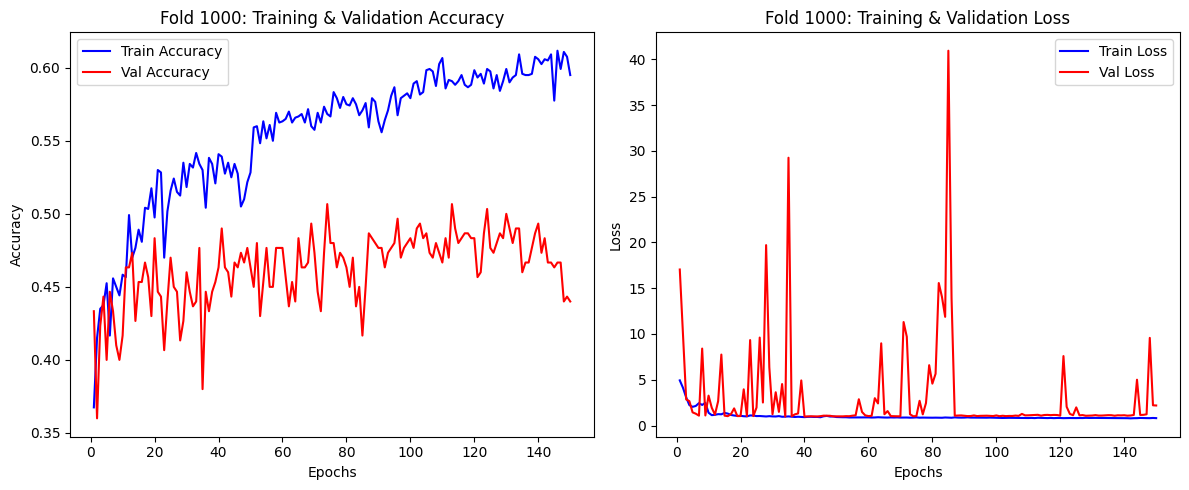


»»» Testing Hidden Dimension: 128 «««
[Elapsed: 0:08:31] [RAM: 1498.1 MB] --- Fold 1000: Initializing GIN ---
[Elapsed: 0:08:31] [RAM: 1498.1 MB] Starting Training Loop...
[Elapsed: 0:08:41] [RAM: 1498.1 MB] Epoch 010 | Train: 1.8775 | Val: 1.1309 (Acc: 0.4367)
[Elapsed: 0:08:50] [RAM: 1498.1 MB] Epoch 020 | Train: 1.2816 | Val: 1.8878 (Acc: 0.4533)
[Elapsed: 0:09:00] [RAM: 1498.1 MB] Epoch 030 | Train: 1.0044 | Val: 1.0211 (Acc: 0.4367)
[Elapsed: 0:09:10] [RAM: 1498.1 MB] Epoch 040 | Train: 0.9439 | Val: 2.1573 (Acc: 0.4533)
[Elapsed: 0:09:20] [RAM: 1498.1 MB] Epoch 050 | Train: 0.9354 | Val: 233.3549 (Acc: 0.4633)
[Elapsed: 0:09:29] [RAM: 1498.1 MB] Epoch 060 | Train: 0.8905 | Val: 1.0919 (Acc: 0.4667)
[Elapsed: 0:09:38] [RAM: 1498.1 MB] Epoch 070 | Train: 0.8680 | Val: 3.8869 (Acc: 0.4733)
[Elapsed: 0:09:48] [RAM: 1498.1 MB] Epoch 080 | Train: 0.8633 | Val: 8.5314 (Acc: 0.4600)
[Elapsed: 0:09:58] [RAM: 1498.1 MB] Epoch 090 | Train: 0.8667 | Val: 108.4046 (Acc: 0.4600)
[Elapsed: 0:1

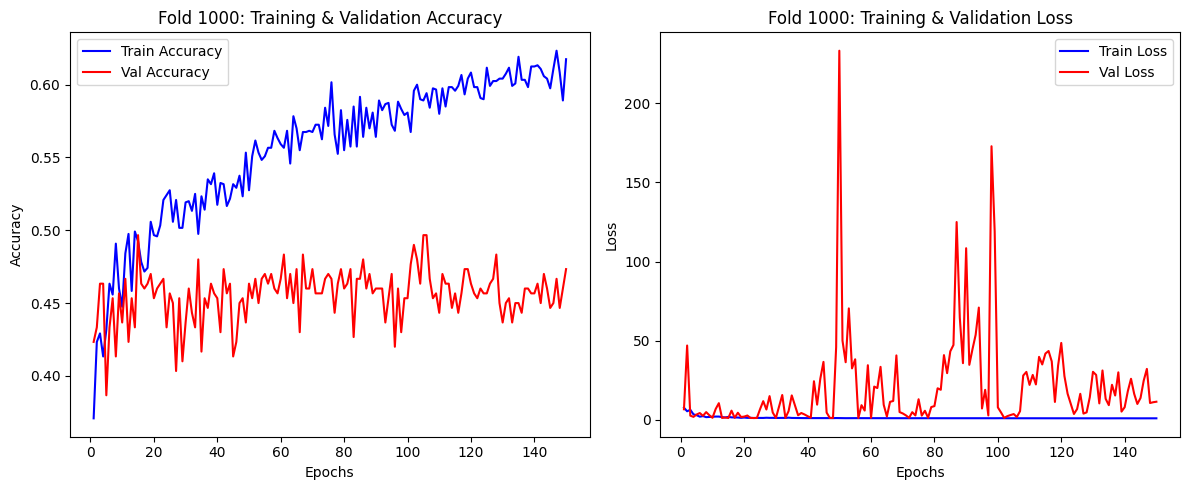


»»» Testing Hidden Dimension: 256 «««
[Elapsed: 0:10:57] [RAM: 1498.1 MB] --- Fold 1000: Initializing GIN ---
[Elapsed: 0:10:57] [RAM: 1498.1 MB] Starting Training Loop...
[Elapsed: 0:11:07] [RAM: 1498.2 MB] Epoch 010 | Train: 1.6475 | Val: 7.0385 (Acc: 0.3833)
[Elapsed: 0:11:16] [RAM: 1498.2 MB] Epoch 020 | Train: 1.4162 | Val: 30.5063 (Acc: 0.4033)
[Elapsed: 0:11:26] [RAM: 1498.2 MB] Epoch 030 | Train: 1.0989 | Val: 2.9504 (Acc: 0.4500)
[Elapsed: 0:11:36] [RAM: 1498.2 MB] Epoch 040 | Train: 1.1798 | Val: 89.2714 (Acc: 0.4600)
[Elapsed: 0:11:46] [RAM: 1498.2 MB] Epoch 050 | Train: 1.0102 | Val: 16.1835 (Acc: 0.4500)
[Elapsed: 0:11:55] [RAM: 1498.2 MB] Epoch 060 | Train: 0.9156 | Val: 12.7213 (Acc: 0.4300)
[Elapsed: 0:12:05] [RAM: 1498.2 MB] Epoch 070 | Train: 0.9246 | Val: 50.1980 (Acc: 0.4467)
[Elapsed: 0:12:14] [RAM: 1498.2 MB] Epoch 080 | Train: 0.8805 | Val: 110.6617 (Acc: 0.4267)
[Elapsed: 0:12:24] [RAM: 1498.2 MB] Epoch 090 | Train: 0.8816 | Val: 152.8375 (Acc: 0.4233)
[Elapsed

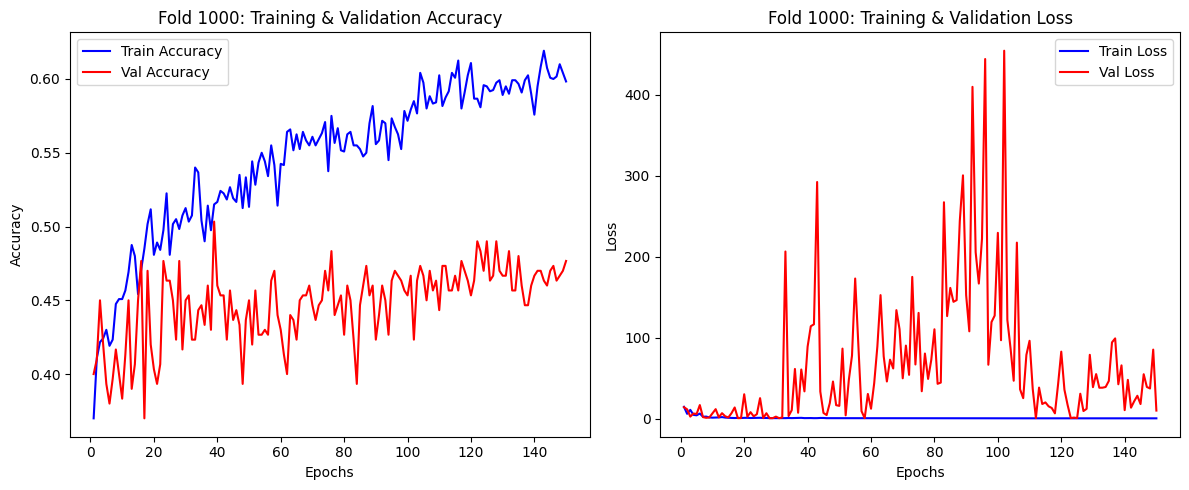

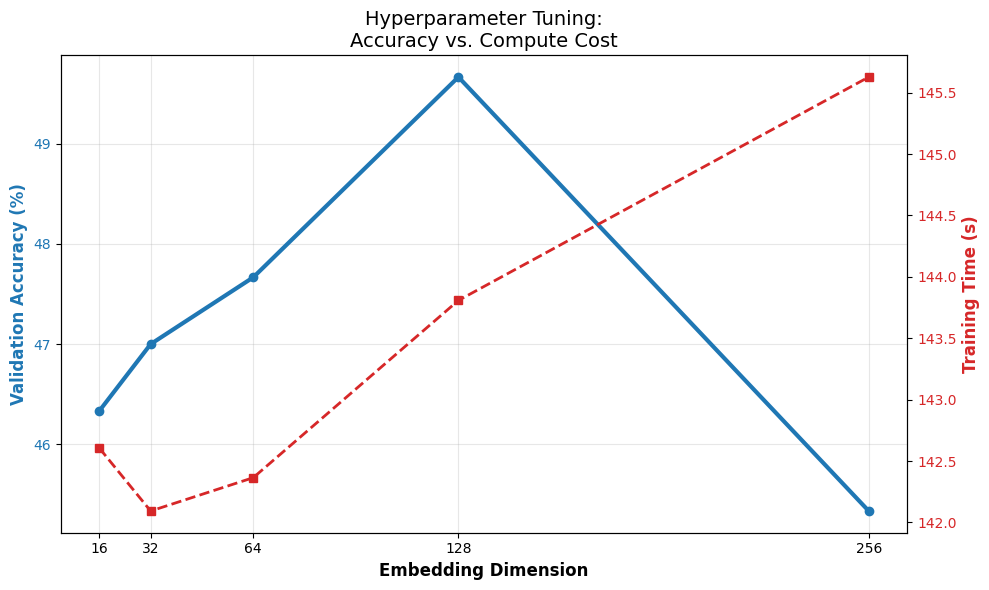

[Plot] Saved tuning tradeoff to tuning_tradeoff_plot.png

[Tuning] Completed. Check 'tuning_tradeoff_plot.png'.

Pipeline Finished in 12.11 minutes.


In [22]:
# ==============================================================================
# CONFIGURATION
# ==============================================================================
DATASET_NAME = 'IMDB-MULTI'
run_pipeline(run_dataset_analysis=False, run_main_experiment=False, enable_stability=False, run_hyperparameter_tuning=True, n_folds=10)